In [2]:
# Importando Librerias

import pandas as pd
import os, string, unicodedata, re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.util import ngrams
import nltk
from tensorflow.keras.utils import to_categorical
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.models import Sequential
import keras.utils as ku 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import random
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.regularizers import l2
from keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import seaborn as sns



#

# **1. RECLASIFICANDO df_csv con df_clasificador**

## **1.1 Leyendo los archivos**

In [3]:
df_csv =  pd.read_csv('informacion_roles_actualizado.csv')

df_clasificador = pd.read_excel('CLASIFICADO_FINAL.xlsx')

- `df_csv`: Contiene los datos que tenemos que reclasificar con el dataframe df_clasificador
- `df_clasificador` corresponde al df donde se encuentran las etiquetas bien clasificadas

In [4]:
df_csv.head()

,rol,corte,fecha,folio,tramite,descripcion,fecha_ingreso
0,144280-2022,Valparaíso,05/02/2024,26.0,Actuación,COMUNICA CÚMPLASE CS,31/10/2022
1,144280-2022,Valparaíso,05/02/2024,25.0,Actuación,COMUNICA CÚMPLASE CS,31/10/2022
2,144280-2022,Valparaíso,05/02/2024,24.0,Resolución,Cúmplase CS,31/10/2022
3,144280-2022,Valparaíso,05/12/2023,23.0,Escrito,Recurso fallado Corte Suprema,31/10/2022
4,144280-2022,Valparaíso,15/06/2023,22.0,Resolución,(NMV)Concede Recurso (Intercon,31/10/2022


In [5]:
df_clasificador.head()

,Unnamed: 0,Descripcion,CLASIFICACION_FINAL
0,1461,Cumple lo ordenado / En Relaci,Téngase presente
1,202,Rec.Prot/D.cta.ONI.Sala Isapre,Dese cuenta
2,200,Cumple previo/Admisible GES,Admisibles
3,2621,Cambio código a masivo,ICA informa
4,1095,ocúrrase donde corresonda,ICA informa


## **1.2 Tratando los dfs**

In [6]:
df_clasificador['CLASIFICACION_FINAL'] = df_clasificador['CLASIFICACION_FINAL'].str.title()

In [7]:
df_clasificador['CLASIFICACION_FINAL'].value_counts()



CLASIFICACION_FINAL
Ica Solicita Diligencia    379
Agréguese A Tabla          319
Ica Informa                289
Evacua Informe             287
Admisibles                 255
Téngase Presente           203
Dese Cuenta                164
Apercibe                   160
Ica Amplia Plazo           138
Nhl                        119
Acoge                       69
Concede Apelación           54
Acuerdo                     43
Certifiquese                39
Cs                          38
Rechazada                   31
Art / Numeral               25
Archivado                   24
Fija Costas                 22
Inhabilidad                 22
Acumulación                 19
Oni                         17
Prescinde                   13
Inadmisible/Omite           13
Incompetencia               12
Multa                        7
Fallo/Desestima              5
Retira                       4
Inicio Tramitación           4
Name: count, dtype: int64

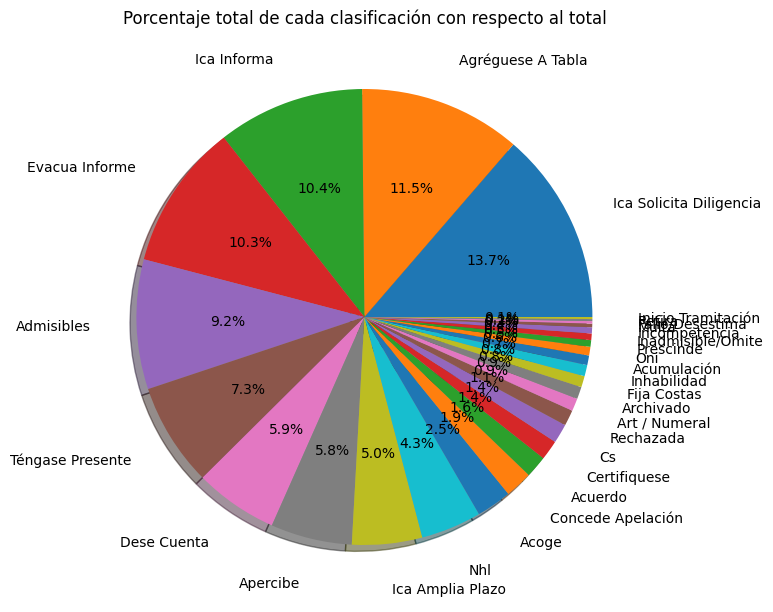

In [8]:
plt.figure(figsize=(10, 6))
plt.pie(df_clasificador['CLASIFICACION_FINAL'].value_counts(), labels=df_clasificador['CLASIFICACION_FINAL'].value_counts().index, autopct='%1.1f%%', labeldistance=1.2, normalize=True, shadow=True)
plt.tight_layout()
plt.title('Porcentaje total de cada clasificación con respecto al total')
plt.show()

- Tenemos bastante categorias que están muy poco presentes como es notorio en nuestro gráfico.
- Esto puede ser un problema considerando el desbalance de clases

### Generar el diccionario para CLASIFICACION FINAL - Descripción

In [9]:
# Genera un diccionario key = la clasificación correcta , value = todas los textos clasificados con esa etiqueta
dict_to_replace = df_clasificador.groupby('CLASIFICACION_FINAL')['Descripcion'].apply(list).to_dict()

- Cada descripción del dataframe se asocia a una respectiva categoria. Con esto podremos recategorizar el dataframe `df_csv`

In [10]:
# Función para reemplazar los datos
def mapear_valor(descripcion: str, diccionario: dict) -> str:

    """
    Toma un diccionario y ve si el valor está en en una cadena de texto. En caso de que esté devuelve la key del diccionario
    en caso de no encontrar concidencia entonces retorna el texto original
    """
    for key, values in diccionario.items():
        for value in values:
            if str(value).lower() in descripcion.lower():
                return key
    return descripcion 


### **CLASIFICANDO LOS VALORES DE df_csv con los valores de df_clasificador**

In [11]:
# Generando una nueva columna en el df que no se encuentra clasificado correctamente reempalzando sus valores según el diccionario clasificador
df_csv['CLASIFICACION_CORRECTA']=df_csv.loc[(df_csv['tramite']=='Resolución') | (df_csv['tramite']=='Sentencia'), :]['descripcion'].apply(lambda x: mapear_valor(x, dict_to_replace))

### **Solo dejando los registros en los cuales el trámite sea resolución o Sentencia**

In [12]:
df_csv = df_csv.loc[(df_csv['tramite']=='Resolución') | (df_csv['tramite']=='Sentencia'), :]

- Debido que en este problema solo nos interesa aquellos trámites que sean o Resolución o Sentencia, solo estos tipos de trámites son incluidos ya que las demás opciones son datos que no nos aportan ningun detalle a nuestro intento de predicciones

# **PROCESADO DEL TEXTO**

In [13]:
df_csv.shape

(50808, 8)

### Solo dejar máximo 5 repeticiones del mismo texto

In [14]:
df_csv['dup_count'] = df_csv.groupby(['descripcion', 'CLASIFICACION_CORRECTA']).cumcount() + 1


In [15]:
max_veces = 5  

df_csv= df_csv[df_csv['dup_count'] <= max_veces]


In [16]:
# Obteniendo la lista de oraciones
sentences =  [ line for line in df_csv['descripcion'].values if line != 'Unknown']

In [17]:
sentences[:10]

['Cúmplase CS',
 '(NMV)Concede Recurso (Intercon',
 'NMV7/Acogida',
 'Agréguese Extraordinariamente',
 '7NMV/Estese al mérito',
 'nmv 3.Téngase Presente',
 '(8) Pide informe ONI',
 '(7)Estese al mérito de autos',
 '(5). Por Evacuado Informe, en',
 '(4)Interpuesto Recurso de Prot']

In [18]:
# Función para limpiar los textos
def cleaning_data(text):
    # Eliminar caracteres de puntuación
    clean_txt = "".join(char for char in text if char not in string.punctuation)
    
    # Normalizar el texto a ASCII
    text_normalized = unicodedata.normalize('NFKD', clean_txt).encode('ascii', 'ignore').decode('ascii')
    
    # Eliminar espacios adicionales y convertir a minúsculas
    text_cleaned = re.sub(r'\s{2,}', ' ', text_normalized).strip().lower()
    
    # Eliminar dígitos y palabras específicas (si no son útiles)
    text_cleaned = re.sub(r'^(\d+)\s|\d+(?=[a-zA-Z])', '', text_cleaned)  # Elimina números
    text_cleaned = re.sub(r'nmv', '', text_cleaned).strip()  # Elimina "nmv"
    
    return text_cleaned


In [19]:
# Oraciones limpias
clean_data = [cleaning_data(t) for t in sentences]

In [20]:
clean_data[:10]

['cumplase cs',
 'concede recurso intercon',
 'acogida',
 'agreguese extraordinariamente',
 'estese al merito',
 'tengase presente',
 'pide informe oni',
 'estese al merito de autos',
 'por evacuado informe en',
 'interpuesto recurso de prot']

## Eliminando las stopwords

In [21]:
import nltk
from nltk.corpus import stopwords

# Descargar las stopwords si no lo has hecho antes
nltk.download('stopwords')

# Obtener las stopwords en español
stop_words_es = set(stopwords.words('spanish'))

print(stop_words_es)

{'estarías', 'sois', 'fueras', 'tuviera', 'esté', 'tuvo', 'estados', 'mucho', 'estabais', 'eran', 'sí', 'suyo', 'yo', 'estuvierais', 'ella', 'suyas', 'os', 'había', 'hubieron', 'fuerais', 'les', 'hube', 'estaréis', 'no', 'ti', 'hayan', 'tuvieron', 'por', 'desde', 'tendríais', 'estuviste', 'este', 'tengamos', 'durante', 'estuvisteis', 'te', 'fueseis', 'esta', 'todos', 'tendrá', 'erais', 'estad', 'seré', 'habremos', 'seréis', 'hayamos', 'estarán', 'estoy', 'fueses', 'sea', 'fuesen', 'habido', 'habrías', 'fueran', 'muy', 'se', 'tanto', 'nuestros', 'tuviéramos', 'estéis', 'estaríamos', 'a', 'fue', 'fui', 'la', 'fuésemos', 'tuviste', 'tuvieran', 'tuyos', 'un', 'siente', 'hubieses', 'tienes', 'hubiesen', 'habrá', 'están', 'fuera', 'antes', 'estas', 'sentido', 'una', 'tenidos', 'hubieran', 'estuvieses', 'teníais', 'hasta', 'tenidas', 'algo', 'sentidas', 'nos', 'serían', 'tengas', 'tengo', 'estemos', 'hubo', 'suyos', 'eras', 'seáis', 'tuvieses', 'todo', 'has', 'teníamos', 'otros', 'estada', 'h

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kev_g\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:

clean_data = [word for word in clean_data if word not in stop_words_es]

## TOKENIZACIÓN

In [23]:

from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words= 2300, oov_token="<OOV>")

In [24]:
tokenizer.fit_on_texts(clean_data)

# Al vocabulario total que tenemos le sumamos 1 para asegurarnos que incluya el indice 0 del pading (tokenizer.word_index = dict)
total_words = len(tokenizer.word_index) + 1 

sequences = tokenizer.texts_to_sequences(clean_data)

max_sequence_len = max([len(x) for x in sequences])



In [25]:
df_csv['CLASIFICACION_CORRECTA'].value_counts()

CLASIFICACION_CORRECTA
Agréguese A Tabla          909
Evacua Informe             744
Admisibles                 717
Ica Solicita Diligencia    533
Ica Informa                485
Ica Amplia Plazo           402
Dese Cuenta                380
Apercibe                   265
Téngase Presente           251
Acoge                      188
Nhl                        174
Concede Apelación          171
Cs                         108
Certifiquese                82
Acuerdo                     73
Archivado                   71
Fija Costas                 55
Rechazada                   55
Art / Numeral               54
Acumulación                 41
Oni                         33
Inadmisible/Omite           30
Inhabilidad                 26
Incompetencia               26
Prescinde                   21
Fallo/Desestima             12
Retira                       8
Multa                        8
Inicio Tramitación           7
Name: count, dtype: int64

- Existe un desbalanceo de clases evidente ya que para algunos caso no cambia mucho en como viene representados los datos

In [26]:
from sklearn.preprocessing import LabelEncoder

# 1. Convertir etiquetas de texto a números
label_encoder = LabelEncoder()
df_csv['CLASIFICACION_NUM'] = label_encoder.fit_transform(df_csv['CLASIFICACION_CORRECTA'])


# 2. Convertir etiquetas numéricas a one-hot encoding
y_categorical = to_categorical(df_csv['CLASIFICACION_NUM'])

In [27]:
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_len, padding='pre')

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y_categorical, test_size=0.3, random_state=42)



## **3. MODELACIÓN**

In [28]:

# Definición del modelo
model = Sequential()

# Capa de Embedding
model.add(Embedding(input_dim=total_words, output_dim=50, input_length=max_sequence_len))

# Capa LSTM
model.add(LSTM(128, return_sequences=False, kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.5))

# Capa densa
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.2))

# Capa de salida
model.add(Dense(y_categorical.shape[1], activation='softmax'))

# Compilación del modelo
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)

# Resumen del modelo
model.summary()





c:\DEEP_LEARNING\Project_1\myenv\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [29]:


# Compilación del modelo
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Entrenamiento con class_weights
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=20, batch_size=32, 
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.1571 - loss: 2.9909 - val_accuracy: 0.3108 - val_loss: 2.2344 - learning_rate: 0.0010
Epoch 2/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.3739 - loss: 1.9842 - val_accuracy: 0.6639 - val_loss: 1.4311 - learning_rate: 0.0010
Epoch 3/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.6279 - loss: 1.3452 - val_accuracy: 0.7105 - val_loss: 1.0639 - learning_rate: 0.0010
Epoch 4/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - accuracy: 0.7343 - loss: 0.9631 - val_accuracy: 0.7836 - val_loss: 0.8908 - learning_rate: 0.0010
Epoch 5/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.7921 - loss: 0.7578 - val_accuracy: 0.8117 - val_loss: 0.8113 - learning_rate: 0.0010
Epoch 6/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.8356 - loss: 0.6264 - val_accuracy: 0.8083 - val_loss: 0.7567 - learning_rate: 0.0010
Epoch 7/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.8466 - loss: 0

In [30]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def metricas_clases(X_test, model):

    """
    Función que genera probabilidades para el conjunto de prueba y las combierte a las clases predichas. También genera informe de clasificación y matriz de confusion.
    return: Retorna un dataframe con el clasification report.
    """
    # Predecir las probabilidades para el conjunto de prueba
    y_pred_probs = model.predict(X_test)

    # Convertir las probabilidades a clases predichas
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Obtener las etiquetas reales
    y_true = np.argmax(y_test, axis=1)

    # Generar el informe de clasificación
    print("Informe de clasificación:")
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))
    
    classification_report_dict = classification_report(y_true, y_pred, target_names=label_encoder.classes_, output_dict=True)

    df_cr = pd.DataFrame(classification_report_dict).transpose()

    # Generar la matriz de confusión
    cm = confusion_matrix(y_true, y_pred)

    # Visualizar la matriz de confusión
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.ylabel('Etiqueta Real')
    plt.xlabel('Etiqueta Predicha')
    plt.title('Matriz de Confusión')
    plt.show()

    return df_cr

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Informe de clasificación:
                         precision    recall  f1-score   support

                  Acoge       1.00      0.90      0.95        52
                Acuerdo       0.96      1.00      0.98        22
            Acumulación       0.93      0.81      0.87        16
             Admisibles       0.99      0.99      0.99       233
      Agréguese A Tabla       0.99      1.00      0.99       252
               Apercibe       0.93      0.97      0.95        70
              Archivado       0.95      0.86      0.90        22
          Art / Numeral       0.94      0.77      0.85        22
           Certifiquese       1.00      0.58      0.73        31
      Concede Apelación       0.93      1.00      0.96        51
                     Cs       1.00      0.92      0.96        36
            Dese Cuenta       0.93      0.98      0.95       113
         Evacua Informe       0.93      0.94      0.93       219
        Fallo/Desestima

c:\DEEP_LEARNING\Project_1\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\DEEP_LEARNING\Project_1\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\DEEP_LEARNING\Project_1\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\DEEP_LEARNING

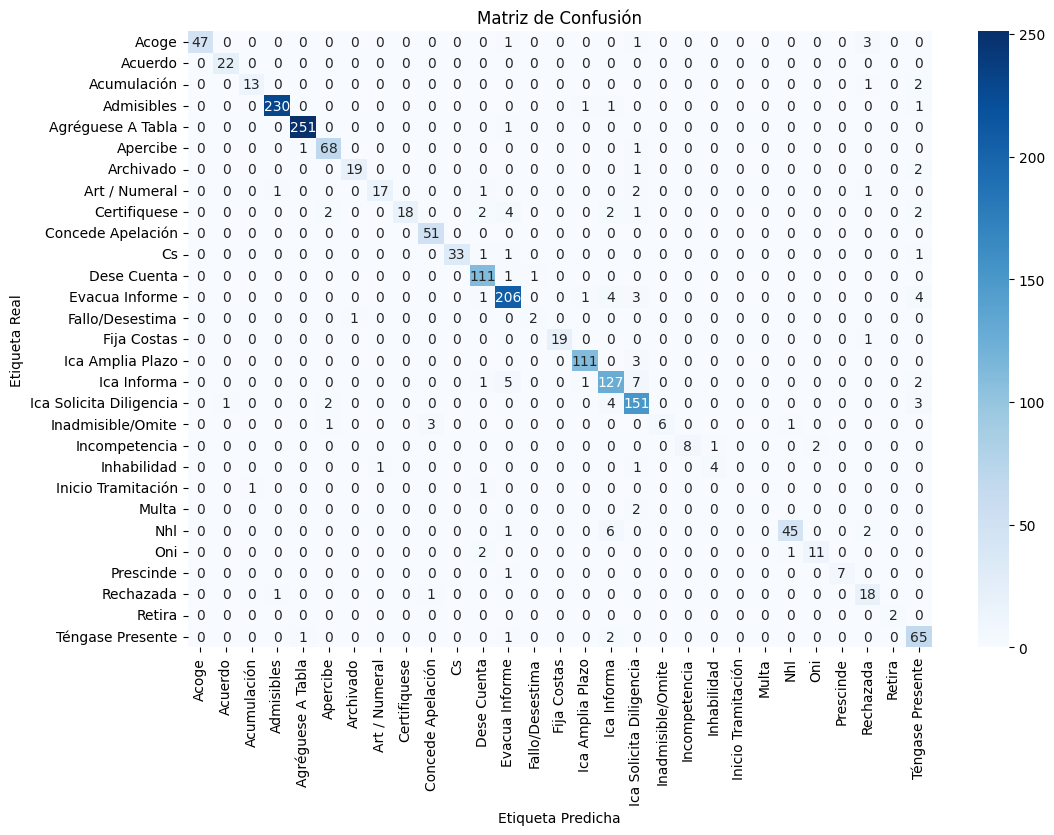

In [31]:
df_clasificacion_sin_tratar = metricas_clases(X_test, model)

- El modelo en general se desempeña bastante bien con excepcion de las clases que tienen bajo soporte como:
    - Fallo/Desestima
    - Multa
    - Retira

- Hay clases que tienen metricas excepcionalmente buena como admisible, agreguese a tabla

## **3.1 DESBALANCEO DE CLASES**

In [32]:

# Definición del modelo
model = Sequential()

# Capa de Embedding
model.add(Embedding(input_dim=total_words, output_dim=50, input_length=max_sequence_len))

# Capa LSTM
model.add(LSTM(128, return_sequences=False, kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.5))

# Capa densa
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.2))

# Capa de salida
model.add(Dense(y_categorical.shape[1], activation='softmax'))

# Compilación del modelo
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)





c:\DEEP_LEARNING\Project_1\myenv\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


- Al mismo modelo anterior vamos a realizar un class_weights para ver si podemos mejorar las clases que tienen mal desempeño

### **3.1.2 Balanceando las clases con class_weights**

In [33]:
y_train_int = y_train.argmax(axis=1)  # De one-hot a entero


In [34]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_int), y=y_train_int)
class_weights_dict = dict(enumerate(class_weights))

history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=20, batch_size=32, 
                    class_weight=class_weights_dict,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.0577 - loss: 3.4824 - val_accuracy: 0.2552 - val_loss: 2.7726 - learning_rate: 0.0010
Epoch 2/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.2765 - loss: 3.1058 - val_accuracy: 0.5048 - val_loss: 1.7892 - learning_rate: 0.0010
Epoch 3/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.4999 - loss: 2.1678 - val_accuracy: 0.6363 - val_loss: 1.3398 - learning_rate: 0.0010
Epoch 4/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.6238 - loss: 1.6727 - val_accuracy: 0.7903 - val_loss: 0.8399 - learning_rate: 0.0010
Epoch 5/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.7423 - loss: 1.3279 - val_accuracy: 0.8449 - val_loss: 0.6462 - learning_rate: 0.0010
Epoch 6/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.8061 - loss: 0.8491 - val_accuracy: 0.8550 - val_loss: 0.6167 - learning_rate: 0.0010
Epoch 7/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.8349 - loss: 0

56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
Informe de clasificación:
                         precision    recall  f1-score   support

                  Acoge       0.98      0.90      0.94        52
                Acuerdo       0.88      1.00      0.94        22
            Acumulación       0.70      0.88      0.78        16
             Admisibles       1.00      0.98      0.99       233
      Agréguese A Tabla       1.00      0.99      0.99       252
               Apercibe       0.86      0.94      0.90        70
              Archivado       0.90      0.82      0.86        22
          Art / Numeral       0.95      0.86      0.90        22
           Certifiquese       0.93      0.42      0.58        31
      Concede Apelación       0.93      0.98      0.95        51
                     Cs       0.93      0.78      0.85        36
            Dese Cuenta       0.96      0.97      0.97       113
         Evacua Informe       0.88      0.90      0.89       219
        Fallo/Desestima

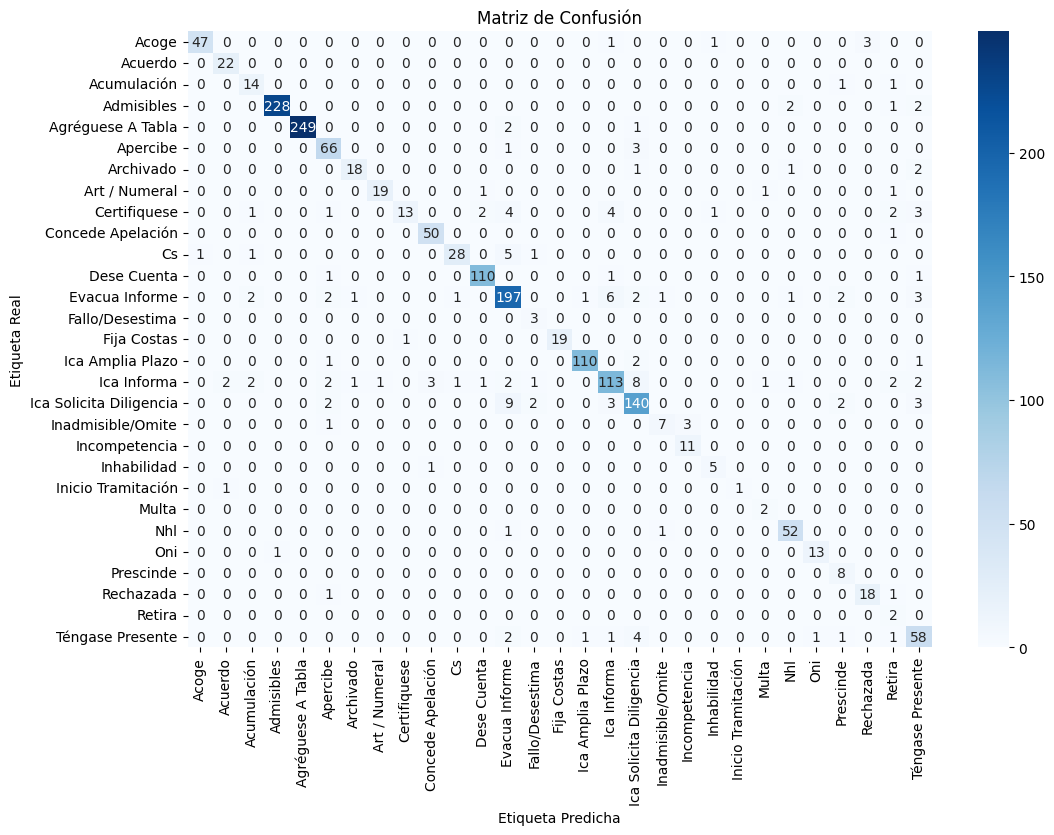

In [35]:
df_classweights = metricas_clases(X_test, model)

## **2.3 Resumen hasta ahora**

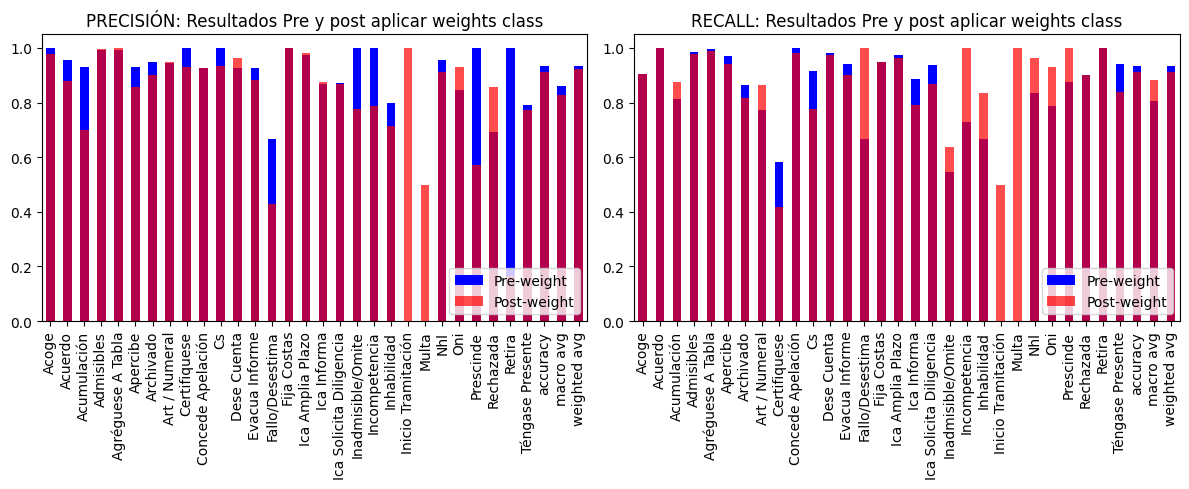

In [36]:
df_resumen = pd.concat([df_clasificacion_sin_tratar, df_classweights], axis=1)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Precision
df_clasificacion_sin_tratar.iloc[:, 0].plot(kind='bar', label='Pre-weight', color='blue', ax=ax[0])
df_classweights.iloc[:, 0].plot(kind='bar', alpha=0.7, color='red', label='Post-weight', ax = ax[0])

ax[0].legend(loc='lower right')
ax[0].set_title('PRECISIÓN: Resultados Pre y post aplicar weights class')

# Recall
df_clasificacion_sin_tratar.iloc[:, 1].plot(kind='bar', label='Pre-weight', color='blue', ax=ax[1])
df_classweights.iloc[:, 1].plot(kind='bar', alpha=0.7, color='red', label='Post-weight', ax = ax[1])

ax[1].legend(loc='lower right')
ax[1].set_title('RECALL: Resultados Pre y post aplicar weights class')

plt.tight_layout()
plt.show()


### **Clases resultante con menor precision**
`Acuerdo`, `Acumulación`, `Apercibe`, `Archivado`, `Art / Numeral`, `ICA Solicita Diligencia`, `Inhabilidad`, `ONI`, `Precinde` y por último el macro avg

### **Clases mejoradas**

`Fallo/Desestima`, `Inadmisible/Omite`, `Multa`, `NHL`, `Téngase presente`

Logramos el cometido de poder sacar de 0 precision las clases con el class weights pero debido lo más probable al bajo soporte y ejemplos disponibles tenemos muy bajas **precisiones < 50 %**


### **MÉTRICA MÁS IMPORTANTE**

En nuestro caso la **precision** es lo más importante porque buscamos tratar de equivocarnos lo menos posible al clasificar los textos. Por esta razon o necesitamos unir alguna categoria con otra para disminuir la cantidad de clases y asi aumentar los ejemplos de las clases minoritarias o aplicar SMOTE con el riesgo de introducir ruido dentro de nuestros datos

### **CONCLUSIÓN**

#### Las clases con problemas son las siguientes:
- Acuerdo, Acumulación, Apercibe, Archivado, Certifiquese,  Fallo/Desestima, Fija Costas, Ica Solicita Diligencia, Inhabilidad, Multa, Nhl, Retira
Prescinde

Por lo tanto intetaremos aplicar **SMOTE** 


## APLICANDO SMOTE EN VEZ DE CLASS_WEIGHTS

In [37]:

padded_sequences = pad_sequences(sequences, maxlen=max_sequence_len, padding='pre')


X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y_categorical, test_size=0.2, random_state=42)
# 2. Convertir etiquetas de una codificación categórica (one-hot) a valores enteros
y_train_int = y_train.argmax(axis=1)  # De one-hot a entero

# 3. Aplicar SMOTE para generar datos sintéticos
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train_int)

# 4. Volver a convertir las etiquetas generadas por SMOTE a one-hot encoding
y_train_resampled = to_categorical(y_train_resampled, num_classes=y_categorical.shape[1])

# Verificar los tamaños después de SMOTE
print(f"Tamaño original: {X_train.shape}, Tamaño después de SMOTE: {X_train_resampled.shape}")

Tamaño original: (4743, 163), Tamaño después de SMOTE: (21257, 163)


In [38]:

# Definición del modelo
model = Sequential()

# Capa de Embedding
model.add(Embedding(input_dim=total_words, output_dim=50, input_length=max_sequence_len))

# Capa LSTM
model.add(LSTM(128, return_sequences=False, kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.5))

# Capa densa
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.2))

# Capa de salida
model.add(Dense(y_categorical.shape[1], activation='softmax'))

# Compilación del modelo
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)




c:\DEEP_LEARNING\Project_1\myenv\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [39]:

# Resumen del modelo
model.summary()
history = model.fit(X_train_resampled, y_train_resampled, 
                    validation_data=(X_test, y_test), 
                    epochs=20, batch_size=32, 
                    callbacks=[early_stopping, reduce_lr])

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
665/665 ━━━━━━━━━━━━━━━━━━━━ 39s 55ms/step - accuracy: 0.1675 - loss: 2.9206 - val_accuracy: 0.7133 - val_loss: 1.1587 - learning_rate: 0.0010
Epoch 2/20
665/665 ━━━━━━━━━━━━━━━━━━━━ 33s 50ms/step - accuracy: 0.6457 - loss: 1.3723 - val_accuracy: 0.8128 - val_loss: 0.8214 - learning_rate: 0.0010
Epoch 3/20
665/665 ━━━━━━━━━━━━━━━━━━━━ 34s 51ms/step - accuracy: 0.7126 - loss: 1.1199 - val_accuracy: 0.8415 - val_loss: 0.7141 - learning_rate: 0.0010
Epoch 4/20
665/665 ━━━━━━━━━━━━━━━━━━━━ 34s 51ms/step - accuracy: 0.7551 - loss: 0.9652 - val_accuracy: 0.8575 - val_loss: 0.6272 - learning_rate: 0.0010
Epoch 5/20
665/665 ━━━━━━━━━━━━━━━━━━━━ 38s 57ms/step - accuracy: 0.7797 - loss: 0.8653 - val_accuracy: 0.8702 - val_loss: 0.5881 - learning_rate: 0.0010
Epoch 6/20
665/665 ━━━━━━━━━━━━━━━━━━━━ 33s 49ms/step - accuracy: 0.7977 - loss: 0.7952 - val_accuracy: 0.8685 - val_loss: 0.6278 - learning_rate: 0.0010
Epoch 7/20
665/665 ━━━━━━━━━━━━━━━━━━━━ 40s 60ms/step - accuracy: 0.8139 - l

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Informe de clasificación:
                         precision    recall  f1-score   support

                  Acoge       0.93      0.74      0.82        34
                Acuerdo       0.77      1.00      0.87        17
            Acumulación       0.53      0.69      0.60        13
             Admisibles       0.97      0.97      0.97       160
      Agréguese A Tabla       0.99      0.97      0.98       176
               Apercibe       0.82      0.84      0.83        43
              Archivado       0.86      0.92      0.89        13
          Art / Numeral       0.87      0.81      0.84        16
           Certifiquese       0.75      0.63      0.69        19
      Concede Apelación       1.00      0.97      0.98        30
                     Cs       0.91      0.84      0.88        25
            Dese Cuenta       0.93      0.94      0.94        70
         Evacua Informe       0.95      0.87      0.91       139
        Fallo/Desestima

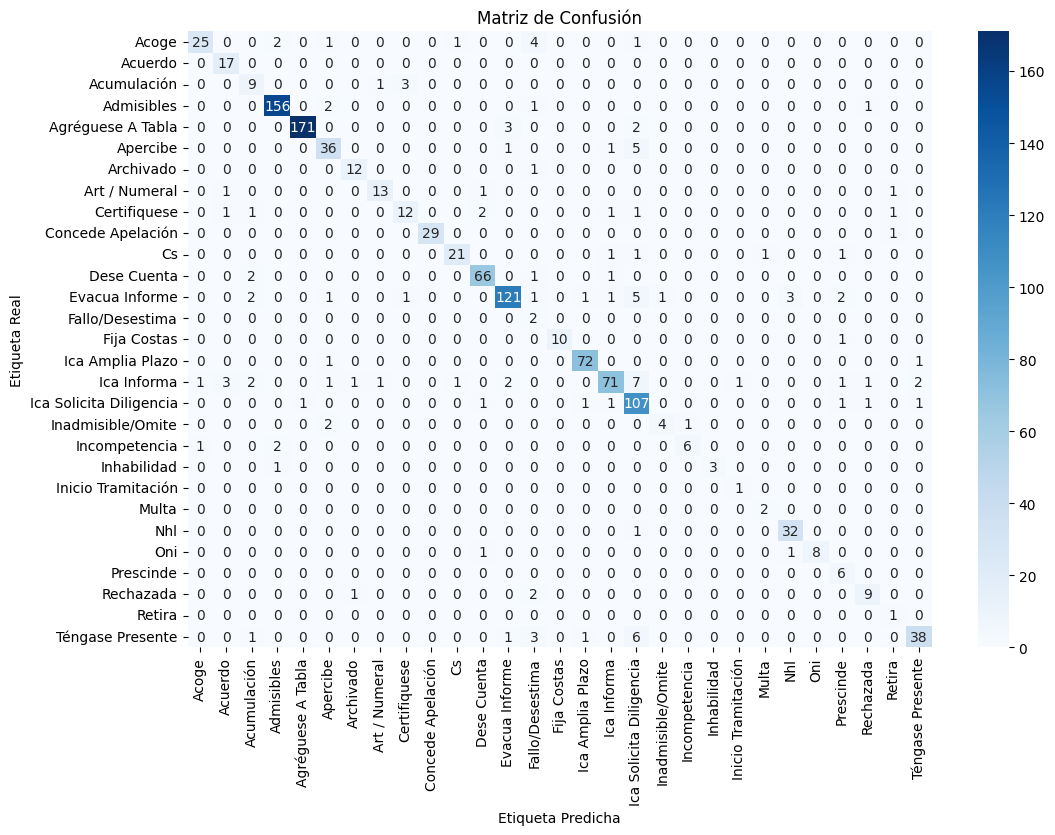

In [40]:
df_smote = metricas_clases(X_test, model)

In [41]:
df_resumen = pd.concat([
    df_clasificacion_sin_tratar.add_suffix('_SIN_TRATAR'),
    df_classweights.add_suffix('_CLASS_WEIGHT'),
    df_smote.add_suffix('_SMOTE')
], axis=1)

In [42]:
df_resumen

,precision_SIN_TRATAR,recall_SIN_TRATAR,f1-score_SIN_TRATAR,support_SIN_TRATAR,precision_CLASS_WEIGHT,recall_CLASS_WEIGHT,f1-score_CLASS_WEIGHT,support_CLASS_WEIGHT,precision_SMOTE,recall_SMOTE,f1-score_SMOTE,support_SMOTE
Acoge,1.000000,0.903846,0.949495,52.000000,0.979167,0.903846,0.940000,52.00000,0.925926,0.735294,0.819672,34.000000
Acuerdo,0.956522,1.000000,0.977778,22.000000,0.880000,1.000000,0.936170,22.00000,0.772727,1.000000,0.871795,17.000000
Acumulación,0.928571,0.812500,0.866667,16.000000,0.700000,0.875000,0.777778,16.00000,0.529412,0.692308,0.600000,13.000000
Admisibles,0.991379,0.987124,0.989247,233.000000,0.995633,0.978541,0.987013,233.00000,0.968944,0.975000,0.971963,160.000000
Agréguese A Tabla,0.992095,0.996032,0.994059,252.000000,1.000000,0.988095,0.994012,252.00000,0.994186,0.971591,0.982759,176.000000
Apercibe,0.931507,0.971429,0.951049,70.000000,0.857143,0.942857,0.897959,70.00000,0.818182,0.837209,0.827586,43.000000
Archivado,0.950000,0.863636,0.904762,22.000000,0.900000,0.818182,0.857143,22.00000,0.857143,0.923077,0.888889,13.000000
Art / Numeral,0.944444,0.772727,0.850000,22.000000,0.950000,0.863636,0.904762,22.00000,0.866667,0.812500,0.838710,16.000000
Certifiquese,1.000000,0.580645,0.734694,31.000000,0.928571,0.419355,0.577778,31.00000,0.750000,0.631579,0.685714,19.000000
Concede Apelación,0.927273,1.000000,0.962264,51.000000,0.925926,0.980392,0.952381,51.00000,1.000000,0.966667,0.983051,30.000000


In [43]:
df_resumen[['precision_SIN_TRATAR', 'precision_CLASS_WEIGHT', 'precision_SMOTE', 'support_SIN_TRATAR', 'support_CLASS_WEIGHT', 'support_SMOTE' ]]

,precision_SIN_TRATAR,precision_CLASS_WEIGHT,precision_SMOTE,support_SIN_TRATAR,support_CLASS_WEIGHT,support_SMOTE
Acoge,1.000000,0.979167,0.925926,52.000000,52.00000,34.000000
Acuerdo,0.956522,0.880000,0.772727,22.000000,22.00000,17.000000
Acumulación,0.928571,0.700000,0.529412,16.000000,16.00000,13.000000
Admisibles,0.991379,0.995633,0.968944,233.000000,233.00000,160.000000
Agréguese A Tabla,0.992095,1.000000,0.994186,252.000000,252.00000,176.000000
Apercibe,0.931507,0.857143,0.818182,70.000000,70.00000,43.000000
Archivado,0.950000,0.900000,0.857143,22.000000,22.00000,13.000000
Art / Numeral,0.944444,0.950000,0.866667,22.000000,22.00000,16.000000
Certifiquese,1.000000,0.928571,0.750000,31.000000,31.00000,19.000000
Concede Apelación,0.927273,0.925926,1.000000,51.000000,51.00000,30.000000


In [44]:
umbral_soporte = df_resumen['support_SMOTE'].median()  # Se puede ajustar según la distribución

# Filtrar las clases con bajo soporte en SMOTE
clases_bajo_soporte = df_resumen[df_resumen['support_SMOTE'] < umbral_soporte]
clases_bajo_soporte

,precision_SIN_TRATAR,recall_SIN_TRATAR,f1-score_SIN_TRATAR,support_SIN_TRATAR,precision_CLASS_WEIGHT,recall_CLASS_WEIGHT,f1-score_CLASS_WEIGHT,support_CLASS_WEIGHT,precision_SMOTE,recall_SMOTE,f1-score_SMOTE,support_SMOTE
Acuerdo,0.956522,1.000000,0.977778,22.000000,0.880000,1.000000,0.936170,22.00000,0.772727,1.000000,0.871795,17.000000
Acumulación,0.928571,0.812500,0.866667,16.000000,0.700000,0.875000,0.777778,16.00000,0.529412,0.692308,0.600000,13.000000
Archivado,0.950000,0.863636,0.904762,22.000000,0.900000,0.818182,0.857143,22.00000,0.857143,0.923077,0.888889,13.000000
Art / Numeral,0.944444,0.772727,0.850000,22.000000,0.950000,0.863636,0.904762,22.00000,0.866667,0.812500,0.838710,16.000000
Fallo/Desestima,0.666667,0.666667,0.666667,3.000000,0.428571,1.000000,0.600000,3.00000,0.133333,1.000000,0.235294,2.000000
Fija Costas,1.000000,0.950000,0.974359,20.000000,1.000000,0.950000,0.974359,20.00000,1.000000,0.909091,0.952381,11.000000
Inadmisible/Omite,1.000000,0.545455,0.705882,11.000000,0.777778,0.636364,0.700000,11.00000,0.800000,0.571429,0.666667,7.000000
Incompetencia,1.000000,0.727273,0.842105,11.000000,0.785714,1.000000,0.880000,11.00000,0.857143,0.666667,0.750000,9.000000
Inhabilidad,0.800000,0.666667,0.727273,6.000000,0.714286,0.833333,0.769231,6.00000,1.000000,0.750000,0.857143,4.000000
Inicio Tramitación,0.000000,0.000000,0.000000,2.000000,1.000000,0.500000,0.666667,2.00000,0.500000,1.000000,0.666667,1.000000


### **CONCLUSION**

Según lo observado con la aplicación del SMOTE no se observa una mejora considerable en las metricas que nos interesa de las clases que tienen menor soporte. Aplicar ya sea un undersampling o un data augmentation podria ser una buena opción. Considerando que ya se aplicó un tratamiento a los datos en si, vamos a tratar de realizar un aumento de datos

## **3. DATA AUGMENTATION**

In [46]:
cortes_de_chile = [
    "Arica",
    "Iquique",
    "Antofagasta",
    "Copiapó",
    "La Serena",
    "Valparaíso",
    "Santiago",
    "Rancagua",
    "Talca",
    "Chillán",
    "Concepción",
    "Temuco",
    "Valdivia",
    "Puerto Montt",
    "Coyhaique",
    "Punta Arenas"
]

abreviaciones_cortes = [
    "ARC",  # Arica
    "IQQ",  # Iquique
    "ANT",  # Antofagasta
    "COP",  # Copiapó
    "SER",  # La Serena
    "VALP",  # Valparaíso (también se usa "VALPO")
    "STGO",  # Santiago
    "RCGA",  # Rancagua (también se usa "RANC")
    "TAL",  # Talca
    "CHILL",  # Chillán
    "CCP",  # Concepción
    "TEM",  # Temuco
    "VALD",  # Valdivia
    "PMO",  # Puerto Montt (también se usa "PTOM")
    "COY",  # Coyhaique
    "PA"  # Punta Arenas
]


formas_corte_apelaciones = [
    "C.A.",
    "CA",
    "Corte Apel.",
    "Ilma. C.A.",
    "Ilustrísima Corte de Apelaciones",
    "Excelentísima Corte de Apelaciones",
    "Corte de Apelaciones de",
    "Corte de",
    "Apelaciones de",
    "Tribunal de Apelaciones"
]

variaciones_recurrente_recurrida = [
    "Recurrida",
    "Recurrente",
    "Rte.",  
    "Rcta.",  
    "Rcte.",  
    "Rcrte.", 
    "Rcrda.",  
    "Recurrda",  
    "Recurr.",  
    "Rdo.",  
    "Rda.", 
    "Recur.",  
    "Demandante recurrente",
    "Demandado recurrente",
    "Apelante",
    "Impugnante"
]

random.seed(42)


In [47]:

variaciones_acuerdo = [
    f"Estése a la disponibilidad de esta corte de apelaciones de { random.choice(abreviaciones_cortes)} a su ingreso y prioridad.",
    f"Estése a la disponibilidad de esta corte de apelaciones de {random.choice(cortes_de_chile)} a su ingreso y prioridad.",
    "Pase a los ministros del acuerdo.",
    f"Rija el estado de acuerdo {random.choice(abreviaciones_cortes)}.",
    "Acuerdo.",
    "Nota de acuerdo: redacción Erika Villegas.",
    "Certifica alegato y acuerdo.",
    "Cert. de acuerdo.",
    "Nota de acuerdo: redacción ministra Valentina Salvo.",
    "Nota de acuerdo: redacción Jimena Troncoso.",
    "Nota de acuerdo: redacción Jimena Troncoso.", 
    "Acogida (fallo del acuerdo).",
    "Incorpórese a la tabla respectiva de acuerdo a su disponibilidad.",
    "Nota de acuerdo: redacción Sra. Valentina Salvo.",
    "Certificado causa en acuerdo.",
    "Nota de acuerdo: redacción Rafael Andrade Díaz.",
    "Nota de acuerdo: redacción Gonzalo Roja.",
    "Nota de acuerdo, redacción Sr. Gonzalo Montroy.",
    "Suspensión vista de común acuerdo art. 165 N° 5 C.P.C.",
    "Nota de acuerdo: redacción Claudia Vilches.",
    "Pase a los ministros del acuerdo a la sala.",
    "Nota de acuerdo redacción: Hadolff Ascencio.",
    "Nota de acuerdo: designa redacción Gonzalo Rojas.",
    "Nota de acuerdo: redacción Valentina Calvo.",
    "Nota de acuerdo: redacción Rafael Andrade.",
    "Nota de acuerdo: redacción Camilo Álvarez.",
    "Pase a los min del acuerdo.",
    "En acuerdo (R. Cerda, V. Iza y MF. Durán).",
    "En acuerdo (R. Cerda, MF. Durán y M. Escobar).",
    "Nota acuerdo.",
    "Nota de acuerdo redacción Mauricio Silva.",
    "Nota de acuerdo: Sr. Gonzalo Montroy.",
    "Nota de acuerdo: redacción Gonzalo Montroy.",
    "Pase a ministros del acuerdo.",
    "Nota de acuerdo.",
    "Certif. alegato y acuerdo.",
    "Certificado de acuerdo.",
    "Certificado alegato y acuerdo.",
    "En acuerdo.",
    "Cert. acuerdo.",
    "Nota acuerdo.",
    "Certificado tránsito del estudio al acuerdo.",
    "Certificación acuerdo.",
    "Certificación causa en acuerdo.",
    "Acuerdo.",
    "Pase a ministros acuerdo.",
    "Nota de acuerdo, redacción Maximiliano Escobar.",
    "Al folio 52: por cumplido lo ordenado, rija el estado de acuerdo.",
    "Certif. acuerdo."
]

def generar_frase_acuerdo():
    """
    Selecciona de forma aleatoria una de las variaciones definidas para la clase "Acuerdo".
    """
    return random.choice(variaciones_acuerdo)

# Generar varias frases para la clase "Acuerdo"
frases_acuerdo = [generar_frase_acuerdo() for _ in range(200)]

In [48]:
import random
# Lista de variaciones para la clase "Apercibe"
apercibe_variations = [
    f"Para apercibe hace efectivo apercibimiento a {random.choice(variaciones_recurrente_recurrida)}.",
    "Previo a proveer, hágase coincidir la suma con el cuerpo del escrito, dentro del plazo establecido, bajo apercibimiento de resolver conforme al mérito de autos.",
    "Atendido el tiempo transcurrido, se hace efectivo el apercibimiento decretado.",
    "Se notifica apercibimiento a la parte recurrente.",
    "Se impone apercibimiento conforme a lo resuelto en autos.",
    f"No habiendo informado, se procede al apercibimiento {random.choice(variaciones_recurrente_recurrida)} .",
    "Apercibimiento: se deja sin efecto la resolución y se ordena archivar los antecedentes.",
    "Se ordena apercibimiento a la parte para que cumpla en plazo.",
    "Ante la inactividad, se declara apercibimiento y se procede a archivar la causa.",
    "Se realiza apercibimiento y se advierte multa en caso de incumplimiento.",
    f"Apercibimiento efectivo a la parte {random.choice(variaciones_recurrente_recurrida)}, comuníquese y archívese.",
    "Se notifica apercibimiento a la parte para cumplir con lo ordenado.",
    "Se procede al apercibimiento, solicitando informe dentro del plazo establecido.",
    "Apercibimiento decretado, a falta de respuesta.",
    "Bajo apercibimiento, se requiere respuesta en cinco días hábiles.",
    "El apercibimiento se efectúa debido a la inacción de la parte recurrida.",
    "Apercibimiento: se deja constancia en autos de la inacción de la parte.",
    "Se notifica a la parte, bajo apercibimiento, que de no responder en el plazo se procederá a archivar la causa.",
    "Por falta de respuesta, se hace efectivo el apercibimiento.",
    f"Se ordena el apercibimiento, advirtiendo medidas en caso de incumplimiento de {random.choice(variaciones_recurrente_recurrida)}."
]

def generar_frase_apercibe():
    """
    Selecciona aleatoriamente una de las variaciones definidas para la clase "Apercibe".
    """
    return random.choice(apercibe_variations)

# Generar varias frases aleatorias para la clase "Apercibe"
frases_apercibe = [generar_frase_apercibe() for _ in range(200)]

# Mostrar algunas de las frases generadas (por ejemplo, las 10 primeras)
for frase in frases_apercibe[:10]:
    print(frase)

Atendido el tiempo transcurrido, se hace efectivo el apercibimiento decretado.
El apercibimiento se efectúa debido a la inacción de la parte recurrida.
Atendido el tiempo transcurrido, se hace efectivo el apercibimiento decretado.
Se notifica a la parte, bajo apercibimiento, que de no responder en el plazo se procederá a archivar la causa.
Se impone apercibimiento conforme a lo resuelto en autos.
Se impone apercibimiento conforme a lo resuelto en autos.
El apercibimiento se efectúa debido a la inacción de la parte recurrida.
Se notifica a la parte, bajo apercibimiento, que de no responder en el plazo se procederá a archivar la causa.
No habiendo informado, se procede al apercibimiento Recurrente .
Ante la inactividad, se declara apercibimiento y se procede a archivar la causa.


In [49]:
import random

# Genera un número aleatorio de 3 dígitos
def generar_num_3():
    return str(random.randint(100, 999))

# Genera un número aleatorio de 4 dígitos
def generar_num_4():
    return str(random.randint(1000, 9999))

# Genera roles en el formato xxx-yyyy
def generar_rol():
    return f"{generar_num_3()}-{generar_num_4()}"

def generar_frase_aleatoria():
    rol1 = generar_rol()
    rol2 = generar_rol()
    abreviaturas = ['Acum.', 'Acumula', 'Acum. a', 'Se acumula a', 'Acumulado a', 'acumúlese', 'tengase por acumulado', 'tgse acumla', 'tp acum0']
    abreviatura = random.choice(abreviaturas)  # Escoge una sola abreviatura
    variaciones = [
        f'{abreviatura} {rol1} con {rol2} de la corte de {random.choice(cortes_de_chile)}.',
        f'{abreviatura} {rol1}, con {rol2} de la corte de {random.choice(abreviaciones_cortes)}',
        f'{abreviatura} {rol1} (con {rol2}).',
        f'{abreviatura} {rol1}  con {rol2}.',
        f'El rol {rol1} {abreviatura} {rol2}.',
        f'El rol {rol1}, {abreviatura} {rol2}.',
        f'El rol {rol1} ({abreviatura} {rol2}).',
        f'El rol {rol1}  {abreviatura} {rol2}.',
    ]
    return random.choice(variaciones)

# Generar 10 frases aleatorias
frases_acumula = [generar_frase_aleatoria() for _ in range(300)]
frases_acumula[:10]

['El rol 145-1058 (Acumulado a 441-3143).',
 'Acum. a 674-1158 (con 214-2232).',
 'acumúlese 540-3088  con 142-6050.',
 'acumúlese 798-5088  con 782-2684.',
 'El rol 985-3662, tengase por acumulado 919-3900.',
 'El rol 901-7745 (Acumulado a 921-5065).',
 'El rol 993-1634, Se acumula a 979-8711.',
 'El rol 412-4728 Se acumula a 328-1387.',
 'acumúlese 985-2137 con 891-5573 de la corte de Valdivia.',
 'El rol 218-5279, Acum. 282-5349.']

In [50]:
import random

tipo = ['sentencia', 'recurso', 'lo obrado', 'fallo', 'sin costas', 'con costas', 'fallo']

frases_fallo = [
    'Por el {} y por desestimada',
    'Se desestima el {}.',
    'El {} es desestimado.',
    'compl. {}- desestimada pb',
    'compl. {}- desestimada pb',
    'compl. {}- desestima ges',
    'compl. {}- prima extraordinaria'
]

# Funciones para variar la frase
def variar_frase(item):
    variaciones = [
        (f'se desestima, la {item}', 'comas'),
        (f'Téngase por desestimada la {item}', 'sin comas'),
        (f'tgse  (la {item}) desestimada', 'parentesis'),
        (f'se desestima  la {item}', 'dos espacios'),
        (f'se desestima el {item}', 'el en lugar de la'),
        (f'téngase por desestimado el {item}', 'el en lugar de la')
    ]
    
    if item == 'lo obrado':
        return f'se desestima {item}.'
    else:
        return random.choice(variaciones)[0]

def generar_frase_aleatoria():
    item = random.choice(tipo)
    if item == 'fallo':
        frase = random.choice(frases_fallo)
        if frase:  
            return frase.format(item)
        else:
            return variar_frase(item)
    elif item in ['sin costas', 'con costas']:
        return f'{item} {random.choice(["son desestimadas", "se desestiman"])}'
    else:
        return variar_frase(item)



frases_fallo_desestima = [generar_frase_aleatoria() for _ in range(300)]
frases_fallo_desestima[:10]

['se desestima lo obrado.',
 'compl. fallo- prima extraordinaria',
 'se desestima el recurso',
 'El fallo es desestimado.',
 'Por el fallo y por desestimada',
 'compl. fallo- desestima ges',
 'con costas se desestiman',
 'se desestima lo obrado.',
 'tgse  (la sentencia) desestimada',
 'téngase por desestimado el sentencia']

In [51]:
conceptos = ['costos', 'valores', 'tarifas', 'precios', 'cotizaciones']
medidas = ['UTM', 'UF', 'pesos', 'dólares', 'unidades']
valores = ['100.000', '200.000', '300.000', '400.000', '500.000', '3', '5', '7', '10', '15']
cortes = ['Santiago', 'Concepción', 'Ccp', 'stgo', 'Arica', 'Puerto Montt', 'Punta Arenas']

def variar_frase(concepto, medida, valor, corte):
    variaciones = [
        # Variaciones con nombres de Cortes de Apelaciones
        f'La Corte de Apelaciones de {corte} fija los {concepto} en {valor} {medida}.',
        f'Por resolución de la Corte de Apelaciones de {corte}, se fijan los {concepto} en {valor} {medida}.',
        f'Los {concepto} han sido fijados por la Corte de Apelaciones de {corte} en {valor} {medida}.',
        f'La Corte de Apelaciones de {corte} determina los {concepto} en {valor} {medida}.',
        f'En {corte}, la Corte de Apelaciones establece los {concepto} en {valor} {medida}.',
        f'Se informa que la Corte de Apelaciones de {corte} ha fijado los {concepto} en {valor} {medida}.',
        f'Por auto acordado de la Corte de Apelaciones de {corte}, los {concepto} quedan en {valor} {medida}.',
        f'La Corte de Apelaciones de {corte} manifiesta que los {concepto} están fijados en {valor} {medida}.',
        
        # Con errores comunes
        f'La Corte de Apelaciones de {corte} fija los {concepto} en {valor} {medida}',  # Falta de punto al final
        f'Por resolución de la Corte de Apelaciones de {corte}, se fijan los {concepto} en {valor} {medida}',  # Falta de punto al final
        f'Los {concepto} han sido fijados por la Corte de Apelaciones de {corte} en {valor} {medida}',  # Falta de punto al final
        f'La Corte de Apelaciones de {corte} determina los {concepto} en {valor} {medida}',  # Falta de punto al final
        f'En {corte}, la Corte de Apelaciones establece los {concepto} en {valor} {medida}',  # Falta de punto al final
        f'Se informa que la Corte de Apelaciones de {corte} ha fijado los {concepto} en {valor} {medida}',  # Falta de punto al final
        f'Por auto acordado de la Corte de Apelaciones de {corte}, los {concepto} quedan en {valor} {medida} ',  # Espacio extra al final
        f'La Corte de Apelaciones de {corte} manifiesta que los{concepto} están fijados en {valor} {medida}',  # Espacio faltante
    ]
    return random.choice(variaciones)

def generar_frase_aleatoria():
    concepto = random.choice(conceptos)
    medida = random.choice(medidas)
    valor = random.choice(valores)
    corte = random.choice(cortes)
    return variar_frase(concepto, medida, valor, corte)

# Generar varias frases aleatorias
frases_fijacion = [generar_frase_aleatoria() for _ in range(200)]
print(frases_fijacion[:10])

['La Corte de Apelaciones de Puerto Montt fija los cotizaciones en 400.000 UTM.', 'La Corte de Apelaciones de Santiago manifiesta que loscostos están fijados en 400.000 UTM', 'Por resolución de la Corte de Apelaciones de Concepción, se fijan los tarifas en 300.000 dólares.', 'La Corte de Apelaciones de Ccp manifiesta que los cotizaciones están fijados en 400.000 dólares.', 'Los precios han sido fijados por la Corte de Apelaciones de Punta Arenas en 500.000 pesos.', 'Por resolución de la Corte de Apelaciones de Arica, se fijan los cotizaciones en 200.000 pesos.', 'En Santiago, la Corte de Apelaciones establece los valores en 10 UF', 'Por resolución de la Corte de Apelaciones de Punta Arenas, se fijan los costos en 500.000 dólares', 'La Corte de Apelaciones de stgo fija los tarifas en 10 UTM.', 'Por resolución de la Corte de Apelaciones de Arica, se fijan los tarifas en 500.000 UF']


In [52]:
infracciones = [
    'no cumplir con la normativa migratoria',
    'infringir leyes laborales',
    'falta de seguridad laboral',
    'incumplimiento de normas de protección al consumidor',
    'contaminación ambiental',
    'infracciones viales graves',
    'incumplimiento en entrega de información a afiliados de isapres',
    'negativa injustificada de cobertura por parte de isapres',
    'aumento desproporcionado de planes de isapres',
    'falta de transparencia en contratos de isapres'
]

rangos_utm = [
    'de 10 a 50 UTM',
    'de 50 a 100 UTM',
    'de 1 a 10 UTM',
    'de 20 a 200 UTM',
    'de 5 a 25 UTM',
    'de 1 a 5 UTM',
    'de 100 a 300 UTM',
    'de 500 a 1000 UTM'
]

def variar_frase(infraccion, rango):
    variaciones = [
        f'La multa por {infraccion} es de {rango}.',
        f'La multa por {infraccion}, es de {rango}.',
        f'La multa por {infraccion} (de {rango}) será aplicada.',
        f'La multa por {infraccion}  es de {rango}.',
        f'Se impuso una multa de {rango} por {infraccion}.',
        f'Se impuso una multa, de {rango}, por {infraccion}.',
        f'Se impuso una multa (de {rango}) por {infraccion}.',
        f'Se impuso una multa  de {rango} por {infraccion}.',
        f'Se estableció una multa de {rango} por {infraccion}.',
        f'Por {infraccion}, se sancionó con una multa de {rango}.',
        f'Por {infraccion}, se multó con un rango de {rango}.',
        f'El monto de la multa por {infraccion} será de {rango}.',
        f'La infracción de {infraccion} conlleva una multa de {rango}.',
        f'Debido a {infraccion}, se determinó una multa de {rango}.',
        f'La sanción por {infraccion} consiste en una multa de {rango}.',
        f'Por {infraccion}, se establece una multa de {rango}.',
        f'Se aplicará una multa de {rango} por {infraccion}.',
        f'Por no cumplir con {infraccion}, la multa es de {rango}.',
        f'La multa por la infracción de {infraccion} asciende a {rango}.',
        f'La comisión de {infraccion} se multa con {rango}.',
        # Incluyendo errores comunes
        f'La multa por {infraccion} es de {rango}',  # Falta de punto al final
        f'La multa por {infraccion}, es de {rango}',  # Coma en lugar de punto
        f'la multa por {infraccion} es de {rango}.',  # Sin mayúscula inicial
        f'La multa por {infraccion} es de {rango}',  # Falta de punto al final
        f'La multa por {infraccion} es de {rango},',  # Coma en lugar de punto al final
        f'La multa por {infraccion} es de {rango}..',  # Punto extra al final
        f'La multa por {infraccion} es de {rango} ',  # Espacio al final
        f'Se impuso una multa de {rango} por {infraccion}',  # Falta de punto al final
    ]
    return random.choice(variaciones)

def generar_frase_aleatoria():
    infraccion = random.choice(infracciones)
    rango = random.choice(rangos_utm)
    return variar_frase(infraccion, rango)

# Generar varias frases aleatorias
frases_multa = [generar_frase_aleatoria() for _ in range(300)]
print(frases_multa[:10])

['La sanción por infringir leyes laborales consiste en una multa de de 500 a 1000 UTM.', 'Por infracciones viales graves, se establece una multa de de 50 a 100 UTM.', 'La infracción de no cumplir con la normativa migratoria conlleva una multa de de 50 a 100 UTM.', 'Por no cumplir con incumplimiento en entrega de información a afiliados de isapres, la multa es de de 10 a 50 UTM.', 'La multa por aumento desproporcionado de planes de isapres es de de 10 a 50 UTM ', 'Se aplicará una multa de de 5 a 25 UTM por infringir leyes laborales.', 'La multa por aumento desproporcionado de planes de isapres es de de 20 a 200 UTM', 'El monto de la multa por negativa injustificada de cobertura por parte de isapres será de de 1 a 5 UTM.', 'Se impuso una multa de de 20 a 200 UTM por no cumplir con la normativa migratoria', 'Por no cumplir con negativa injustificada de cobertura por parte de isapres, la multa es de de 1 a 5 UTM.']


In [53]:
# Frases legales variadas con más naturalidad y variabilidad

plantillas_frases = [
    "No ha lugar lo solicitado por la {recurrente} ante la {corte}.",
    "NHL lo solicitado por la {recurrente} ante la {corte}.",
    "Se rechaza lo requerido por la {recurrente} en la {corte}.",
    "Se niega lo solicitado por la {recurrente} en la {corte}.",
    "No ha lugar a la petición de la {recurrente} en la {corte}.",
    "Se desestima la solicitud de la {recurrente} presentada en la {corte}.",
    "La {corte} rechaza lo pedido por la {recurrente}.",
    "No se da lugar a lo requerido por la {recurrente} en la {corte}.",
    "Se deniega la solicitud de la {recurrente} en la {corte}.",
    "La solicitud presentada por la {recurrente} ha sido rechazada en la {corte}.",
    "La {corte} ha decidido no dar lugar a lo solicitado por la {recurrente}."
]

# Generar frases con variabilidad realista
# Generar frases con mayor variabilidad usando random.choice para elegir cortes y recurrentes aleatoriamente

frases_no_ha_lugar_var = []

for _ in range(300):  # Generar 500 frases variadas
    frase = random.choice(plantillas_frases)  # Seleccionar una plantilla al azar
    corte = random.choice(cortes_de_chile)  # Seleccionar una corte al azar
    abreviacion = random.choice(abreviaciones_cortes)  # Seleccionar una abreviatura al azar
    var_recurrente = random.choice(variaciones_recurrente_recurrida)  # Seleccionar una variación al azar

    # Formatos variados de la corte
    corte_formato = random.choice([
        f"Corte de Apelaciones de {corte}",
        f"C.A. {abreviacion}",
        f"Ilustrísima Corte de Apelaciones de {corte}",
        f"Tribunal de Apelaciones de {corte}"
    ])

    frases_no_ha_lugar_var.append(frase.format(recurrente=var_recurrente, corte=corte_formato))

frases_no_ha_lugar_var



['La Ilustrísima Corte de Apelaciones de Temuco rechaza lo pedido por la Demandante recurrente.',
 'No se da lugar a lo requerido por la Recurrda en la Corte de Apelaciones de Valparaíso.',
 'No ha lugar a la petición de la Demandante recurrente en la C.A. PMO.',
 'Se rechaza lo requerido por la Recurrida en la C.A. PA.',
 'La Tribunal de Apelaciones de Punta Arenas rechaza lo pedido por la Rda..',
 'No ha lugar a la petición de la Demandante recurrente en la Corte de Apelaciones de Talca.',
 'Se rechaza lo requerido por la Recurr. en la Tribunal de Apelaciones de Iquique.',
 'La Ilustrísima Corte de Apelaciones de Copiapó ha decidido no dar lugar a lo solicitado por la Rda..',
 'Se desestima la solicitud de la Recur. presentada en la Corte de Apelaciones de Temuco.',
 'La C.A. TEM rechaza lo pedido por la Rcrda..',
 'No ha lugar a la petición de la Impugnante en la Tribunal de Apelaciones de Temuco.',
 'NHL lo solicitado por la Apelante ante la C.A. CHILL.',
 'Se rechaza lo requerido 

In [54]:
partes = ['demandante', 'demandado', 'tercero interesado', 'acusado', 'fiscala', 'recurrida', 'rcte', 'recurrente']
solicitudes = ['presentar pruebas', 'comparecer', 'notificar', 'cumplir con la orden judicial', 'pagar la fianza','dar cumplimiento']

def variar_frase(parte, solicitud):
    variaciones = [
        f'Prescinde de la {parte}, por no {solicitud}.',
        f'Prescinde de la {parte} por no {solicitud}.',
        f'Prescinden, de la {parte}, por no {solicitud}.',
        f'Prescinden (de la {parte}) por no {solicitud}.',
        f'Prescinden  de la {parte} por no {solicitud}.',
        f'La corte prescinde de la {parte} por no {solicitud}.',
        f'Se prescinde, de la {parte}, por no {solicitud}.',
        f'téngase  (de la {parte}) por no {solicitud}.',
        f'La corte prescinde  de la {parte} por no {solicitud}.',
        f'La corte ha prescindido de la {parte} por no {solicitud}.',
       f'La ica ha prescindido de la {parte} por no {solicitud}.',
        f'La ica de santiago ha prescindido de la {parte} por no {solicitud}.',


    ]
    return random.choice(variaciones)

def generar_frase_aleatoria():
    parte = random.choice(partes)
    solicitud = random.choice(solicitudes)
    return variar_frase(parte, solicitud)

# Generar varias frases aleatorias
frases_prescinde = [generar_frase_aleatoria() for _ in range(300)]
frases_prescinde[:10]

['La ica ha prescindido de la demandante por no presentar pruebas.',
 'Prescinden (de la recurrida) por no notificar.',
 'La corte prescinde de la rcte por no notificar.',
 'Prescinde de la recurrente por no presentar pruebas.',
 'Prescinden, de la demandante, por no pagar la fianza.',
 'téngase  (de la tercero interesado) por no presentar pruebas.',
 'Prescinden (de la demandado) por no presentar pruebas.',
 'La corte ha prescindido de la recurrente por no pagar la fianza.',
 'Prescinden (de la recurrida) por no cumplir con la orden judicial.',
 'Prescinde de la recurrida por no comparecer.']

In [55]:

recursos = ['recurso', 'demanda', 'apelación', 'solicitud', 'acción', 'la presente acción']
motivos = [
    'falta de pruebas',
    'error procesal',
    'desistimiento',
    'prescripción',
    'incumplimiento de cobertura por parte de la isapre',
    'negativa de trámite por parte de la isapre',
    'falta de información proporcionada por la isapre',
    'aumento injustificado de costos por la isapre',
    'discrepancia en el cálculo de planes por la isapre',
    'incumplimiento de plazos administrativos por la isapre',
    'por no dar cumplimiento a lo solicitado'
    
]

def variar_frase(item, motivo):
    variaciones = [
        # Correctas
        f'Retira el {item}, por {motivo}.',
        f'El recurrido retira {item}, por {motivo}.',
        f'Retira el {item} por {motivo}.',
        f'Retira (el {item}) por {motivo}.',
        f'Retira  el {item} por {motivo}.',
        f'El {item} es retirado por {motivo}.',
        f'El {item} es retirado, por {motivo}.',
        f'El {item} es retirado (por {motivo}).',
        f'El {item} es retirado  por {motivo}.',
        f'Se ha retirado el {item} por {motivo}.',
        f'Se ha retirado, el {item}, por {motivo}.',
        f'Por {motivo}, se retira el {item}.',
        f'El {item} fue retirado debido a {motivo}.',
        f'La parte retira el {item} por {motivo}.',
        
        # Con errores comunes
        f'Retira el {item}, por {motivo}',  # Falta de punto al final
        f'El recurrido retira {item}, por {motivo}',  # Falta de punto al final
        f'Retira el {item} por {motivo}',  # Falta de punto al final
        f'Retira (el {item}) por {motivo}',  # Falta de punto al final
        f'Retira  el {item} por {motivo}',  # Espacio extra
        f'El {item} es retirado por {motivo}',  # Falta de punto al final
        f'El {item} es retirado, por {motivo}',  # Coma incorrecta
        f'El {item} es retirado (por {motivo})',  # Falta de punto al final
        f'El {item} es retirado  por {motivo}',  # Espacio extra
        f'Se ha retirado el {item} por {motivo}',  # Falta de punto al final
        f'Se ha retirado, el {item}, por {motivo}',  # Coma incorrecta
        f'Por {motivo}, se retira el {item}',  # Falta de punto al final
        f'El {item} fue retirado debido a {motivo}',  # Falta de punto al final
        f'La parte retira el {item} por {motivo} ',  # Espacio extra al final
    ]
    return random.choice(variaciones)

def generar_frase_aleatoria():
    recurso = random.choice(recursos)
    motivo = random.choice(motivos)
    return variar_frase(recurso, motivo)

# Generar varias frases aleatorias
frases_retira = [generar_frase_aleatoria() for _ in range(300)]
print(frases_retira[:10])

['Retira el la presente acción por falta de pruebas', 'Retira el demanda, por negativa de trámite por parte de la isapre', 'Retira  el demanda por prescripción.', 'Se ha retirado, el la presente acción, por por no dar cumplimiento a lo solicitado', 'La parte retira el apelación por falta de información proporcionada por la isapre.', 'El apelación es retirado, por error procesal', 'El demanda es retirado  por falta de información proporcionada por la isapre.', 'El apelación es retirado por por no dar cumplimiento a lo solicitado.', 'El apelación es retirado por por no dar cumplimiento a lo solicitado', 'El demanda es retirado (por falta de información proporcionada por la isapre).']


In [56]:
ecursos = ['recurso', 'demanda', 'apelación', 'solicitud', 'acción']
motivos = [
    'falta de pruebas',
    'error procesal',
    'falta de fundamento',
    'extemporaneidad',
    'carecer de interés legítimo',
    'incumplimiento de cobertura por parte de la isapre',
    'negativa de trámite por parte de la isapre',
    'falta de información proporcionada por la isapre',
    'aumento injustificado de costos por la isapre',
    'discrepancia en el cálculo de planes por la isapre',
    'incumplimiento de plazos administrativos por la isapre',
]

def variar_frase(item, motivo):
    variaciones = [
        # Correctas
        f'El {item} se archiva por {motivo}.',
        f'El {item} ha sido archivado por {motivo}.',
        f'Se archiva el {item} debido a {motivo}.',
        f'Por {motivo}, se archiva el {item}.',
        f'El {item} es archivado por {motivo}.',
        f'El {item} se ha archivado por {motivo}.',
        f'Debido a {motivo}, el {item} se archiva.',
        f'El {item} se encuentra archivado por {motivo}.',
        f'La {item} se archiva por {motivo}.',
        f'El {item} fue archivado por {motivo}.',
        f'Por {motivo}, el {item} se archivó.',
        f'El archivo del {item} se debe a {motivo}.',
        f'El {item} pasó a archivo por {motivo}.',
        f'El proceso del {item} se archivó por {motivo}.',
        
        # Con errores comunes
        f'El {item} se archiva por {motivo}',  # Falta de punto al final
        f'El {item} ha sido archivado por {motivo}',  # Falta de punto al final
        f'Se archiva el {item} debido a {motivo}',  # Falta de punto al final
        f'Por {motivo}, se archiva el {item}',  # Falta de punto al final
        f'El {item} es archivado por {motivo}',  # Falta de punto al final
        f'El {item} se ha archivado por {motivo}',  # Falta de punto al final
        f'Debido a {motivo}, el {item} se archiva',  # Falta de punto al final
        f'El {item} se encuentra archivado por {motivo}',  # Falta de punto al final
        f'La {item} se archiva por {motivo} ',  # Espacio extra al final
        f'El {item}se archiva por {motivo}',  # Espacio faltante
    ]
    return random.choice(variaciones)

def generar_frase_aleatoria():
    recurso = random.choice(recursos)
    motivo = random.choice(motivos)
    return variar_frase(recurso, motivo)

# Generar varias frases aleatorias
frases_archivo = [generar_frase_aleatoria() for _ in range(200)]
print(frases_archivo[:10])

['El la presente acción se archiva por incumplimiento de cobertura por parte de la isapre.', 'El solicitud se archiva por falta de fundamento.', 'Se archiva el la presente acción debido a aumento injustificado de costos por la isapre.', 'Por incumplimiento de cobertura por parte de la isapre, el recurso se archivó.', 'El proceso del solicitud se archivó por falta de fundamento.', 'El recurso ha sido archivado por negativa de trámite por parte de la isapre.', 'El la presente acción es archivado por incumplimiento de plazos administrativos por la isapre.', 'Debido a falta de pruebas, el acción se archiva', 'Se archiva el la presente acción debido a incumplimiento de plazos administrativos por la isapre', 'El apelación pasó a archivo por negativa de trámite por parte de la isapre.']


In [57]:
import random

# Lista de recursos (puedes ampliarla si lo deseas)
recursos = ['recurso', 'demanda', 'apelación', 'solicitud', 'acción']

def variar_frase_tramitacion(recurso):
    """
    Genera una frase aleatoria para indicar el inicio de tramitación
    de un recurso, con variaciones en tildes, errores ortográficos y formato.
    """
    variaciones = [
        f"Inicio de tramitación del {recurso}.",
        f"Inicio de tramitación del {recurso}",  # sin punto
        f"Inicio de tramitacion del {recurso}.",   # sin tilde en 'tramitacion'
        f"Iniciado la tramitación del {recurso}.",
        f"Iniciado la tramtiacion del {recurso}.",  # error: 'tramtiacion' en vez de 'tramitación'
        f"Por iniciado la tramitación del {recurso}.",
        f"Por iniciado la tramtiacion del {recurso}.",
        f"Inicio tramitación del {recurso}.",
        f"Inicio tramitacion del {recurso}.",
        f"Inicia la tramitación del {recurso}.",
        f"Inicia la tramtiacion del {recurso}.",
        f"El inicio de tramitación del {recurso} se realizó.",
        f"El inicio de tramtiacion del {recurso} se realizó.",
        f"Se inicia la tramitación del {recurso}.",
        f"Se inicia la tramtiacion del {recurso}.",
        f"El {recurso} inicia su tramitación.",
        f"El {recurso} inicia su tramtiacion.",
        f"Por el inicio de tramitación del {recurso}.",
        f"Por el inicio de tramtiacion del {recurso}.",
        f"Inicio de tramitación en el {recurso}.",
        f"Inicio de tramtiacion en el {recurso}.",
        # Agregar variantes con errores de separación o puntuación
        f"El inicio del {recurso} es por tramitación.",
        f"El inicio del {recurso} es por tramtiacion.",
        f"Inicio, tramitación del {recurso}.",
        f"Inicio tramitación, del {recurso}.",
    ]
    return random.choice(variaciones)

def generar_frase_inicio():
    recurso = random.choice(recursos)
    return variar_frase_tramitacion(recurso)

# Generar varias frases aleatorias
frases_inicio = [generar_frase_inicio() for _ in range(200)]
print(frases_inicio[:10])


['Inicio de tramtiacion en el acción.', 'Inicio tramitacion del apelación.', 'Iniciado la tramitación del demanda.', 'Inicio tramitación del solicitud.', 'Inicio de tramitación del apelación', 'El apelación inicia su tramtiacion.', 'Inicio de tramitacion del demanda.', 'Inicio de tramitación en el acción.', 'Inicio tramitación, del solicitud.', 'Inicio de tramtiacion en el recurso.']


In [ ]:


acciones = ['demanda', 'recurso', 'solicitud', 'apelación', 'petición']
motivos = ['por improcedencia', 'por falta de fundamento', 'por defecto de forma', 'por extemporaneidad', 'por carecer de interés legítimo']

def variar_frase(accion, motivo, accion_corte, tgse):
    variaciones = [
        # Correctas
        f'La corte {accion_corte} la {accion}, {motivo}.',
        f'{tgse} {accion_corte} la {accion} {motivo}.',
        f'La corte {accion_corte}, la {accion}, {motivo}.',
        f'La corte {accion_corte} (la {accion}) {motivo}.',
        f'La corte {accion_corte}  la {accion} {motivo}.',
        f'La {accion} es {accion_corte}a, {motivo}.',
        f'La {accion} es {accion_corte}a  {motivo}.',
        f'La {accion} es {accion_corte}a, {motivo}.',
        f'La {accion} es {accion_corte}a (por {motivo}).',
        f'La {accion} ha sido {accion_corte}a por {motivo}.',
        f'La {accion} fue {accion_corte}a {motivo}.',
        f'La {accion} se considera {accion_corte}a, {motivo}.',
        f'Debido a {motivo}, la {accion} es {accion_corte}a.',
        f'Por {motivo}, la {accion} se {accion_corte}a.',
        f'La corte ha {accion_corte} la {accion} por {motivo}.',
        
        # Con errores comunes
        f'La corte {accion_corte} la {accion}, {motivo}',  # Falta de punto al final
        f'La corte {accion_corte} la {accion} {motivo}',  # Falta de punto al final
        f'La corte {accion_corte}, la {accion}, {motivo}',  # Coma incorrecta
        f'La corte {accion_corte} (la {accion}) {motivo}',  # Falta de punto al final
        f'La corte {accion_corte}  la {accion} {motivo}',  # Espacio extra
        f'La {accion} es {accion_corte}a, {motivo}',  # Falta de punto al final
        f'La {accion} es {accion_corte}a  {motivo}',  # Espacio extra
        f'La {accion} es {accion_corte}a, {motivo}',  # Coma incorrecta
        f'La {accion} es {accion_corte}a (por {motivo})',  # Falta de punto al final
        f'La {accion} es {accion_corte}a por {motivo}',  # Falta de coma
        f'La {accion}es {accion_corte}a {motivo}',  # Espacio faltante
        f'La corte {accion_corte} la {accion}, {motivo}.',  # Punto extra al final
        f'La corte {accion_corte} la {accion} {motivo}.',  # Punto extra al final
        f'La corte {accion_corte} la {accion}, {motivo} ',  # Espacio extra al final
        f'La corte {accion_corte} la {accion} {motivo} ',  # Espacio extra al final
    ]
    return random.choice(variaciones)

def generar_frase_aleatoria():
    accion = random.choice(acciones)
    motivo = random.choice(motivos)
    accion_corte = random.choice(['declara inadmisible', 'omite pronunciamiento sobre', 'omte proncunc.', 'inadmis.', 'inadmisible.', 'omitido'])
    return variar_frase(accion, motivo, accion_corte)

# Generar varias frases aleatorias
frases_omite = [generar_frase_aleatoria() for _ in range(300)]
print(frases_omite[:10])

['La corte declara inadmisible la demanda por carecer de interés legítimo ', 'La corte omte proncunc. (la recurso) por falta de fundamento', 'La corte inadmisible. la petición por carecer de interés legítimo.', 'Debido a por extemporaneidad, la apelación es omite pronunciamiento sobrea.', 'La demanda es inadmis.a  por carecer de interés legítimo.', 'La corte omte proncunc. (la apelación) por improcedencia', 'La apelación es declara inadmisiblea, por defecto de forma.', 'La corte omite pronunciamiento sobre la demanda por carecer de interés legítimo.', 'La petición es declara inadmisiblea, por extemporaneidad.', 'La recurso ha sido inadmis.a por por improcedencia.']


In [131]:
causales = [
    'por parentesco con la parte interesada',
    'por haber intervenido en el caso previamente',
    'por amistad íntima con el acusado',
    'por recibir beneficios de una de las partes',
    'por haber emitido opinión pública sobre el caso',
    'por tener interés directo en el resultado del proceso'
]

profesiones = [
    'ministro de la Corte Suprema',
    'juez de la Corte de Apelaciones',
    'abogado defensor',
    'fiscal',
    'abogado integrante',
    'ministro de tribunal de alzada'
]


nombres = ['Pairican', 'González', 'Muñoz', 'Valenzuela', 'Sepúlveda', 'Rodríguez', 'Pérez', 'Silva', 'Contreras', 'Fuentes']
titulos = ['Sr.', 'Sra.', 'Don', 'Doña', 'Ministro', 'Ministra', 'Juez', 'Jueza', 'Abogado', 'Abogada']

def variar_frase(profesion, causal, titulos, nombres):
    variaciones = [
        # Correctas
        f'El {profesion} se declara inhábil {causal}.',
        f'El {profesion} se declara inhábil, {causal}.',
        f'El {profesion} se declara inhábil (por {causal}).',
        f'El {profesion} se declara inhábil  {causal}.',
        f'La inhabilidad del {profesion} se fundamenta en {causal}.',
        f'La inhabilidad del {profesion}, se fundamenta en {causal}.',
        f'La inhabilidad del {profesion} (se fundamenta en {causal}).',
        f'La inhabilidad del {profesion}  se fundamenta en {causal}.',
        f'Debido a {causal}, el {profesion} se inhabilita.',
        f'El {profesion} manifiesta inhabilidad por {causal}.',
        f'La causa de inhabilidad del {profesion} es {causal}.',
        f'Por {causal}, el {profesion} declara su inhabilidad.',
        f'El {profesion} está inhabilitado debido a {causal}.',
        f'La inhabilidad del {profesion} se basa en {causal}.',
        
        # Con errores comunes
        f'El {profesion} se declara inhábil {causal}',  # Falta de punto al final
        f'El {profesion} se declara inhábil, {causal}',  # Falta de punto al final
        f'El {profesion} se declara inhábil (por {causal})',  # Falta de punto al final
        f'El {profesion} se declara inhábil  {causal}',  # Espacio extra
        f'La inhabilidad del {profesion} se fundamenta en {causal}',  # Falta de punto al final
        f'La inhabilidad del {profesion}, se fundamenta en {causal}',  # Coma incorrecta
        f'La inhabilidad del {profesion} (se fundamenta en {causal})',  # Falta de punto al final
        f'La inhabilidad del {profesion}  se fundamenta en {causal}',  # Espacio extra
        f'Debido a {causal}, el {profesion} se inhabilita',  # Falta de punto al final
        f'El {profesion}se declara inhábil {causal}',  # Espacio faltante
        f'El {profesion} se declara inhábil, {causal}.',  # Punto extra al final
        f'La inhabilidad del {profesion}, se fundamenta en {causal}.',  # Punto extra al final
        f'Debido a {causal} el {profesion} se inhabilita.',  # Espacio faltante
        f'El {profesion} se declara inhábil {causal} ',  # Espacio extra al final

        f"Inhabilidad {titulos} {nombres}",
        f"Se declara inhábil {titulos} {nombres}",
        f"Declaración de inhabilidad de {titulos} {nombres}",
        f"Inhabilidad declarada por {titulos} {nombres}",
        f"{titulos} {nombres} - Inhabilidad",
        f"Inhabilidad - {titulos} {nombres}",
        f"Se inhabilita {titulos} {nombres}"
    ]
    return random.choice(variaciones)

def generar_frase_aleatoria():
    profesion = random.choice(profesiones)
    causal = random.choice(causales)
    titulo = random.choice(titulos)
    nombre = random.choice(nombres)
    return variar_frase(profesion, causal, titulo, nombre)

# Generar varias frases aleatorias
frases_inhabilidad = [generar_frase_aleatoria() for _ in range(300)]
print(frases_inhabilidad[:10])

['La inhabilidad del abogado integrante, se fundamenta en por amistad íntima con el acusado.', 'Abogado Muñoz - Inhabilidad', 'El ministro de la Corte Suprema está inhabilitado debido a por haber emitido opinión pública sobre el caso.', 'Se declara inhábil Juez Sepúlveda', 'La inhabilidad del fiscal se fundamenta en por tener interés directo en el resultado del proceso.', 'Se declara inhábil Abogada Rodríguez', 'La inhabilidad del abogado integrante, se fundamenta en por tener interés directo en el resultado del proceso.', 'El abogado integrante se declara inhábil, por amistad íntima con el acusado.', 'El ministro de la Corte Suprema se declara inhábil por parentesco con la parte interesada ', 'La inhabilidad del juez de la Corte de Apelaciones (se fundamenta en por amistad íntima con el acusado)']


In [60]:
recursos = ['recurso', 'demanda', 'apelación', 'solicitud', 'acción']
decisiones = [
    ('rechaza', 'con costas'),
    ('rechaza', 'sin costas'),
    ('rechaza', 'con costas al demandante'),
    ('rechaza', 'con costas al demandado'),
    ('rechaza', 'con costas repartidas'),
]

motivos = [
    'falta de pruebas',
    'error procesal',
    'falta de fundamento',
    'extemporaneidad',
    'carecer de interés legítimo',
    'incumplimiento de cobertura por parte de la isapre',
    'negativa de trámite por parte de la isapre',
    'falta de información proporcionada por la isapre',
    'aumento injustificado de costos por la isapre',
    'discrepancia en el cálculo de planes por la isapre',
    'incumplimiento de plazos administrativos por la isapre',
]

def variar_frase(item, decision, costo, motivo):
    variaciones = [
        # Correctas
        f'El {item} se {decision}a {costo}, por {motivo}.',
        f'El {item} es {decision}o {costo}, debido a {motivo}.',
        f'Se {decision}a el {item} {costo} por {motivo}.',
        f'Se ha {decision}o el {item} {costo} por {motivo}.',
        f'Debido a {motivo}, el {item} se {decision}a {costo}.',
        f'El {item} ha sido {decision}o {costo} por {motivo}.',
        
        # Con errores comunes
        f'El {item} se {decision}a {costo}, por {motivo}',  # Falta de punto al final
        f'El {item} es {decision}o {costo}, debido a {motivo}',  # Falta de punto al final
        f'Se {decision}a el {item} {costo} por {motivo}',  # Falta de punto al final
        f'Se ha {decision}o el {item} {costo} por {motivo}',  # Falta de punto al final
        f'Debido a {motivo}, el {item} se {decision}a {costo}',  # Falta de punto al final
        f'El {item} ha sido {decision}o {costo} por {motivo}',  # Falta de punto al final
        f'El {item} se {decision}a {costo} por {motivo} ',  # Espacio extra al final
        f'El {item}se {decision}a {costo}, por {motivo}',  # Espacio faltante
    ]
    return random.choice(variaciones)

def generar_frase_aleatoria():
    recurso = random.choice(recursos)
    decision, costo = random.choice(decisiones)
    motivo = random.choice(motivos)
    return variar_frase(recurso, decision, costo, motivo)

# Generar varias frases aleatorias
frases_rechazo = [generar_frase_aleatoria() for _ in range(100)]
print(frases_rechazo[:10])

['El acciónse rechazaa con costas, por falta de información proporcionada por la isapre', 'Se rechazaa el acción sin costas por falta de pruebas.', 'Se ha rechazao el apelación sin costas por error procesal.', 'El recursose rechazaa con costas, por discrepancia en el cálculo de planes por la isapre', 'El solicitud es rechazao sin costas, debido a falta de fundamento', 'El demanda es rechazao con costas repartidas, debido a carecer de interés legítimo', 'El solicitud se rechazaa con costas al demandante por falta de información proporcionada por la isapre ', 'Se rechazaa el recurso con costas al demandante por error procesal.', 'El recurso se rechazaa con costas por discrepancia en el cálculo de planes por la isapre ', 'El demanda se rechazaa con costas repartidas, por falta de fundamento.']


In [173]:
recursos_ica = [
    'ICA',
    'Corte de Apelaciones',
    'C.A.',
    'Tribunal',
    'Corte',
    'El tribunal competente',
    'La Corte de Apelaciones',
    'El órgano jurisdiccional',
    'La autoridad judicial',
    'El juzgado de alzada',
]

acciones_ica = [
    'informar el domicilio contractual y el FUN actualizado del recurrente dentro de 05 días',
    'presentar el FUN contractual actualizado',
    'solicitar el cumplimiento de la sentencia dentro del plazo establecido',
    'presentar los documentos requeridos para la resolución del caso',
    'aclarar los hechos relacionados con el incumplimiento de la sentencia',
    'presentar pruebas adicionales que respalden la demanda',
    'informar sobre el estado actual del cumplimiento de la sentencia',
]

motivos_ica = [
    'para verificar el cumplimiento de la sentencia',
    'para garantizar la transparencia del proceso',
    'para asegurar el cumplimiento de los plazos legales',
    'para resolver discrepancias en la documentación presentada',
    'para aclarar aspectos no definidos en la resolución',
    'para garantizar el derecho a la defensa de las partes',
    'para evaluar la situación actual del caso',
]


import random

def variar_frase_ica(recurso, accion, motivo):
    variaciones = [
        # Correctas
        f'{recurso} solicita {accion} {motivo}.',
        f'solicita {accion} {motivo}.',
        f'{recurso} pide {accion} {motivo}.',
        f'pide {accion} {motivo}.',
        f'{recurso} requiere {accion} {motivo}.',
        f'requiere {accion} {motivo}.',
        f'{recurso} ordena {accion} {motivo}.',
        f'ordena {accion} {motivo}.',
        f'{recurso} exige {accion} {motivo}.',
        f'exige {accion} {motivo}.',
        f'{recurso} demanda {accion} {motivo}.',
         f'demanda {accion} {motivo}.'

    ]
    return random.choice(variaciones)

def generar_frase_ica_aleatoria():
    recurso = random.choice(recursos_ica)
    accion = random.choice(acciones_ica)
    motivo = random.choice(motivos_ica)
    return variar_frase_ica(recurso, accion, motivo)

# Generar varias frases aleatorias
frases_ica = [generar_frase_ica_aleatoria() for _ in range(300)]
print(frases_ica[:10])

['C.A. exige solicitar el cumplimiento de la sentencia dentro del plazo establecido para evaluar la situación actual del caso.', 'ordena presentar el FUN contractual actualizado para garantizar la transparencia del proceso.', 'El juzgado de alzada ordena presentar pruebas adicionales que respalden la demanda para resolver discrepancias en la documentación presentada.', 'ordena informar sobre el estado actual del cumplimiento de la sentencia para garantizar la transparencia del proceso.', 'solicita solicitar el cumplimiento de la sentencia dentro del plazo establecido para verificar el cumplimiento de la sentencia.', 'exige presentar pruebas adicionales que respalden la demanda para resolver discrepancias en la documentación presentada.', 'Corte exige presentar el FUN contractual actualizado para garantizar la transparencia del proceso.', 'El órgano jurisdiccional ordena informar sobre el estado actual del cumplimiento de la sentencia para garantizar la transparencia del proceso.', 'El 

In [62]:
recursos_tengase = [
    "T.P.",
    "Téngase Presente",
    "T. P.",
    "Tga. Pte.",
    "T.P. Sala de Fondo",
    "T.P. Cumplimiento",
    "T.P. Archivo",
    "T.P. Patrocinio",
    "T.P. Pago",
    "T.P. Inf. Cumpl.",
    "Téngase por cumplido"
]

acciones_tengase = [
    "pago de costas",
    "cumplimiento de sentencia",
    "presentación de documentos",
    "informe de cumplimiento",
    "archivo de autos",
    "patrocinio y poder",
    "renuncia y nuevo P y P",
    "ampliación de plazo",
    "desarchivo para cumplimiento",
    "vista de causa",
    "acumulación de documentos"
]

motivos_tengase = [
    "por orden de la Sala de Fondo",
    "según folio N° 16 de autos",
    "para fines pertinentes",
    "por resolución judicial",
    "en atención a lo dispuesto en autos",
    "para garantizar el estricto cumplimiento",
    "por requerimiento de la autoridad competente",
    "en virtud del artículo 45 del Código Procesal",
    "para efectos de notificación",
    "en conformidad a la ley N° 20.190"
]

import random

def variar_frase_tengase(recurso, accion, motivo):
    variaciones = [
        # Correctas
        f'{recurso} {accion} {motivo}.',
        f'{recurso} {accion}, {motivo}.',
        f'{recurso} {accion} ({motivo}).',
        
        # Con errores comunes
        f'{recurso}{accion} {motivo}',  # Falta espacio
        f'{recurso} {accion} {motivo}',  # Falta punto
        f'{recurso} {accion} ({motivo}',  # Falta cerrar paréntesis
        f'{recurso} {accion} {motivo} ',  # Espacio extra
        f'{recurso} {accion.lower()} {motivo}',  # Minúsculas incorrectas
        f'{recurso.replace(".", "")} {accion} {motivo}',  # Falta punto abreviatura
        f'{recurso} {accion} - {motivo}'  # Guión inconsistente
    ]
    return random.choice(variaciones)

def generar_frase_tengase():
    recurso = random.choice(recursos_tengase)
    accion = random.choice(acciones_tengase)
    motivo = random.choice(motivos_tengase)
    return variar_frase_tengase(recurso, accion, motivo)

# Generar 300 frases aleatorias
frases_tengase = [generar_frase_tengase() for _ in range(300)]

# Ejemplos de output (primeras 15 frases)
print("\n".join(frases_tengase[:15]))

Téngase Presente ampliación de plazo por requerimiento de la autoridad competente 
Téngase Presente vista de causa (según folio N° 16 de autos).
T.P. Pago archivo de autos, según folio N° 16 de autos.
T.P. Patrocinio informe de cumplimiento - por orden de la Sala de Fondo
T.P. Pagopatrocinio y poder por orden de la Sala de Fondo
T.P. Sala de Fondo archivo de autos (por requerimiento de la autoridad competente
Téngase Presente presentación de documentos, en atención a lo dispuesto en autos.
TP Pago vista de causa por resolución judicial
T.P. Inf. Cumpl. desarchivo para cumplimiento en atención a lo dispuesto en autos 
T.P. Inf. Cumpl. pago de costas, para efectos de notificación.
T.P. Inf. Cumpl. ampliación de plazo en atención a lo dispuesto en autos.
T.P. patrocinio y poder por requerimiento de la autoridad competente
Tga. Pte. patrocinio y poder (por orden de la Sala de Fondo).
Tga. Pte. desarchivo para cumplimiento para garantizar el estricto cumplimiento.
Tga. Pte. ampliación de pl

In [65]:


cumplase_ = [

    'cúmplase',
    'cúmplase cs',
    'cúmplase corte suprema',
    'c.s.',
    'c.s',
    'Cump',
    "C/se" 

]
acciones =[
    'confirma',
    'revoca',
    'omite',
    'incompetencia',
    'litis pendencia'
]


def variar_frase_tengase(cumplase_, acciones, ):
    variaciones = [
        # Correctas
        f'{cumplase_}/{acciones} .',
        f'{cumplase_} {acciones}.',
        f'{cumplase_} ({acciones}).',
        
        # Con errores comunes
        f'{cumplase_}{acciones}',  # Falta espacio

    ]
    return random.choice(variaciones)

def generar_frase_tengase():
    recurso = random.choice(cumplase_)
    accion = random.choice(acciones)
    return variar_frase_tengase(recurso, accion)

# Generar 300 frases aleatorias
frases_cs = [generar_frase_tengase() for _ in range(300)]

# Ejemplos de output (primeras 15 frases)
print("\n".join(frases_cs[:15]))

cúmplase cs (omite).
Cump (incompetencia).
cúmplase (incompetencia).
c.s (omite).
C/selitis pendencia
C/se/revoca .
C/selitis pendencia
cúmplase cs litis pendencia.
Cump (incompetencia).
Cump omite.
cúmplase corte suprema (litis pendencia).
cúmplase litis pendencia.
cúmplase corte supremarevoca
cúmplase corte suprema/confirma .
c.srevoca


In [174]:
import pandas as pd

# Suponiendo que ya tienes df_ cargado en tu entorno y las listas ya creadas

# Diccionario para asociar categorías con sus respectivas listas de frases
categorias_frases = {
    'Fallo/Desestima': frases_fallo_desestima,
    'Retira': frases_retira,
    'Prescinde': frases_prescinde,
    'Multa': frases_multa,
    'Acumulación':frases_acumula,
    'Fija Costas':frases_fijacion,
    'Acuerdo':frases_acuerdo,
    'Apercibe':frases_apercibe,
    'Archivado':frases_archivo,
    'Inicio Tramitación':frases_inicio,
    'Inadmisible/Omite':frases_omite,
    'Inhabilidad': frases_inhabilidad,
    'Rechazada':frases_rechazo,
    'Ica Solicita Diligencia':frases_ica,
    'Téngase Presente':frases_tengase,
    'Cs':frases_cs


}

# Lista para almacenar las nuevas filas a añadir
nuevas_filas = []

# Generar nuevas filas
for categoria, frases in categorias_frases.items():
    if frases:  # Asegurarse de que hay frases en la lista
        for frase in frases:
            nuevas_filas.append({
                'CLASIFICACION_CORRECTA': categoria,
                'descripcion': frase
            })

# Convertir la lista de diccionarios a DataFrame
nuevas_filas_df = pd.DataFrame(nuevas_filas)



In [175]:
# Mezclar aleatoriamente el DataFrame generado con las frases categorizadas
nuevas_filas_df_shuffled = nuevas_filas_df.sample(frac=1, random_state=42).reset_index(drop=True)



In [176]:
df_csv2 = df_csv.copy()

In [177]:
for col in df_csv.columns:
    if col not in nuevas_filas_df.columns:
        nuevas_filas_df[col] = pd.NA

# Añadir las nuevas filas al DataFrame existente
df = pd.concat([df_csv2, nuevas_filas_df], ignore_index=True)

# Mostrar los últimos registros para verificar
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df

C:\Users\kev_g\AppData\Local\Temp\ipykernel_20164\3602698129.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df_csv2, nuevas_filas_df], ignore_index=True)


,rol,corte,fecha,folio,tramite,descripcion,fecha_ingreso,CLASIFICACION_CORRECTA,dup_count,CLASIFICACION_NUM,text1,text2,text3,text4,text5
0,33824-2019,Concepción,02/09/2020,7.0,Resolución,Certifíquese,07/10/2019,Certifiquese,4,8,Certifíquese,None,None,None,None
1,NaN,NaN,NaN,NaN,NaN,El recurso se rechazaa con costas al demandant...,NaN,Rechazada,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,El demanda fue retirado debido a desistimiento,NaN,Retira,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,solicita presentar el FUN contractual actualiz...,NaN,Ica Solicita Diligencia,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,La corte declara inadmisible la petición por ...,NaN,Inadmisible/Omite,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10024,22189-2024,Concepción,09/12/2024,6.0,Resolución,NHL reposición // Cambio de código,28/11/2024,Ica Informa,5,16,NHL reposición,Cambio de código,None,None,None
10025,6316-2024,Temuco,26/11/2024,10.0,Resolución,Concede ampliación de plazo por el término de ...,27/09/2024,Ica Amplia Plazo,1,15,Concede ampliación de plazo por el término de ...,Rechaza repo rcte,None,None,None
10026,17925-2023,Concepción,14/11/2023,24.0,Resolución,A sus antecedentes//Oficiese al fondo nacional...,20/09/2023,Evacua Informe,1,12,A sus antecedentes,Oficiese al fondo nacional de salud para dar c...,None,None,None
10027,2378-2023,Valdivia,20/08/2024,28.0,Resolución,Dese Cuenta Segunda Sala,05/12/2023,Dese Cuenta,5,11,Dese Cuenta Segunda Sala,None,None,None,None


In [178]:
total_clases_after = len(df['CLASIFICACION_CORRECTA'].unique())
print(f'Total de clases: {total_clases_after}')

Total de clases: 29


In [179]:
df['dup_count'] = df.groupby(['descripcion', 'CLASIFICACION_CORRECTA']).cumcount() + 1

max_veces = 5 
df = df[df['dup_count'] <= max_veces]

In [180]:
sentences =  [ line for line in df['descripcion'].values if line != 'Unknown']
clean_data = [cleaning_data(t) for t in sentences]


In [181]:
clean_data = [
    ' '.join([word for word in sentence.split() if word.lower() not in stop_words_es])
    for sentence in clean_data
]

# Imprimir el resultado
clean_data[:10]

['certifiquese',
 'recurso rechazaa costas demandante carecer interes legitimo',
 'demanda retirado debido desistimiento',
 'solicita presentar fun contractual actualizado garantizar transparencia proceso',
 'corte declara inadmisible peticion extemporaneidad',
 'exige presentar fun contractual actualizado evaluar situacion actual caso',
 'ica prescindido recurrida dar cumplimiento',
 't p ampliacion plazo virtud articulo 45 codigo procesal',
 'corte apelaciones arica manifiesta tarifas estan fijados 100000 pesos',
 'aplicara multa 50 100 utm incumplimiento normas proteccion consumidor']

In [ ]:
with open('clean_data.txt', 'w') as f:
    for sentence in clean_data:
        f.write(sentence + '\n')  # Escribir cada oración seguida de un salto de línea

In [ ]:
with open('clean_data.txt', 'r', encoding='utf-8') as f:
    loaded_data = f.readlines()

# Eliminar los saltos de línea (\n) al final de cada oración
clean_data = [line.strip() for line in loaded_data]

clean_data

['tp inf cumpl desarchivo cumplimiento atencion dispuesto autos',
 'certif acuerdo',
 'desestima obrado',
 'prescinde fiscala presentar pruebas',
 'atendido merito acuerdo tribunal pleno diez julio dos mil veintitres dispone tramitacion presente causa bajo c digo administrativo pr16 debiendo efectuarse cambio respectivo unidad asesor sitcorte requierase unidad cuenta mentada modificacion',
 'concede recurso interconexion',
 'compl fallo desestima ges',
 'pide informe cump sentencia',
 'costas desestiman',
 'concede plazo',
 'pide informe cumpl sentencia',
 'inhabilidad juez corte apelaciones fundamenta recibir beneficios partes',
 'nota acuerdo redaccion camilo alvarez',
 'ges evacuado informe r',
 'tengase presente',
 'interpuesto recurso p',
 'inadmisible pb',
 'informado recurrida pidase cuenta perjuicio reiterese peticion informe tenor recurso dentro plazo cinco dias habiles bajo apercibimiento caso incumplimiento prescindir mismo aplicarle alguna medidas contempla 15 auto acordado

In [219]:

unique_words = set(word for sentence in clean_data for word in sentence.split())
total_words = len(unique_words) + 1 # Total de palabras

print(f'Las palabras unicas son: {total_words}')

Las palabras unicas son: 3217


In [220]:

# 1. Convertir etiquetas de texto a números
label_encoder = LabelEncoder()
df['CLASIFICACION_NUM'] = label_encoder.fit_transform(df['CLASIFICACION_CORRECTA'])


# 2. Convertir etiquetas numéricas a one-hot encoding
y_categorical = to_categorical(df['CLASIFICACION_NUM'])


C:\Users\kev_g\AppData\Local\Temp\ipykernel_20164\2690493204.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CLASIFICACION_NUM'] = label_encoder.fit_transform(df['CLASIFICACION_CORRECTA'])


In [221]:
# Tokenización
tokenizer = Tokenizer(num_words=total_words, oov_token="<OOV>")#2619



tokenizer.fit_on_texts(clean_data)

# Al vocabulario total que tenemos le sumamos 1 para asegurarnos que incluya el indice 0 del pading (tokenizer.word_index = dict)
total_words = len(tokenizer.word_index) + 1 

sequences = tokenizer.texts_to_sequences(clean_data)

max_sequence_len = max([len(x) for x in sequences])



In [222]:
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_len, padding='pre')
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y_categorical, test_size=0.2, random_state=42)

In [223]:
from sklearn.metrics import classification_report, confusion_matrix

def metricas_clases(X_test, y_test ,model):

    """
    Función que genera probabilidades para el conjunto de prueba y las combierte a las clases predichas. También genera informe de clasificación y matriz de confusion.
    return: Retorna un dataframe con el clasification report.
    """
    # Predecir las probabilidades para el conjunto de prueba
    y_pred_probs = model.predict(X_test)

    # Convertir las probabilidades a clases predichas
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Obtener las etiquetas reales
    y_true = np.argmax(y_test, axis=1)

    # Generar el informe de clasificación
    print("Informe de clasificación:")
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))
    
    classification_report_dict = classification_report(y_true, y_pred,  labels=np.arange(28)
        ,target_names=label_encoder.classes_, output_dict=True)

    df_cr = pd.DataFrame(classification_report_dict).transpose()

    # Generar la matriz de confusión
    cm = confusion_matrix(y_true, y_pred)

    # Visualizar la matriz de confusión
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.ylabel('Etiqueta Real')
    plt.xlabel('Etiqueta Predicha')
    plt.title('Matriz de Confusión')
    plt.show()

    return df_cr

### *QUITANDO EL SMOTE*

In [224]:
# Definición del modelo
model = Sequential()

# Capa de Embedding
model.add(Embedding(input_dim=total_words, output_dim=50, input_length=max_sequence_len))

# Capa LSTM
model.add(LSTM(256, return_sequences=False, kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.5))

# Capa densa
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.4))

model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.3))

# Capa de salida
model.add(Dense(y_categorical.shape[1], activation='softmax'))

# Compilación del modelo
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)





c:\DEEP_LEARNING\Project_1\myenv\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [225]:
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_len, padding='pre')
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y_categorical, test_size=0.2, random_state=42)

In [226]:
history2 = model.fit(
    X_train, 
    y_train,
    epochs=10, 
    batch_size=32, 
    validation_data = (X_test, y_test),
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 25s 91ms/step - accuracy: 0.1096 - loss: 3.1122 - val_accuracy: 0.3565 - val_loss: 2.0031 - learning_rate: 0.0010
Epoch 2/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 22s 90ms/step - accuracy: 0.4776 - loss: 1.7202 - val_accuracy: 0.7877 - val_loss: 0.8526 - learning_rate: 0.0010
Epoch 3/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - accuracy: 0.7445 - loss: 0.8759 - val_accuracy: 0.8794 - val_loss: 0.5160 - learning_rate: 0.0010
Epoch 4/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 24s 97ms/step - accuracy: 0.8459 - loss: 0.5684 - val_accuracy: 0.9310 - val_loss: 0.3824 - learning_rate: 0.0010
Epoch 5/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 24s 97ms/step - accuracy: 0.9055 - loss: 0.3998 - val_accuracy: 0.9397 - val_loss: 0.3133 - learning_rate: 0.0010
Epoch 6/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 24s 97ms/step - accuracy: 0.9172 - loss: 0.3278 - val_accuracy: 0.9464 - val_loss: 0.3009 - learning_rate: 0.0010
Epoch 7/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 23s 96ms/step - accuracy: 0.9419 - l

In [227]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9553 - loss: 0.2973
Test Loss: 0.296316921710968, Test Accuracy: 0.9531169533729553


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
Informe de clasificación:
                         precision    recall  f1-score   support

                  Acoge       0.97      0.88      0.93        42
                Acuerdo       0.98      1.00      0.99        53
            Acumulación       0.92      0.99      0.95        74
             Admisibles       0.99      0.99      0.99       144
      Agréguese A Tabla       0.99      0.99      0.99       179
               Apercibe       0.92      0.99      0.95        69
              Archivado       1.00      0.95      0.97        56
          Art / Numeral       0.92      1.00      0.96        12
           Certifiquese       0.80      0.63      0.71        19
      Concede Apelación       0.82      0.88      0.85        26
                     Cs       0.93      0.99      0.96        87
            Dese Cuenta       0.99      0.98      0.98        81
         Evacua Informe       0.92      0.95      0.93       142
        Fallo/Desestima

c:\DEEP_LEARNING\Project_1\myenv\lib\site-packages\sklearn\metrics\_classification.py:2687: UserWarning: labels size, 28, does not match size of target_names, 29
  warnings.warn(


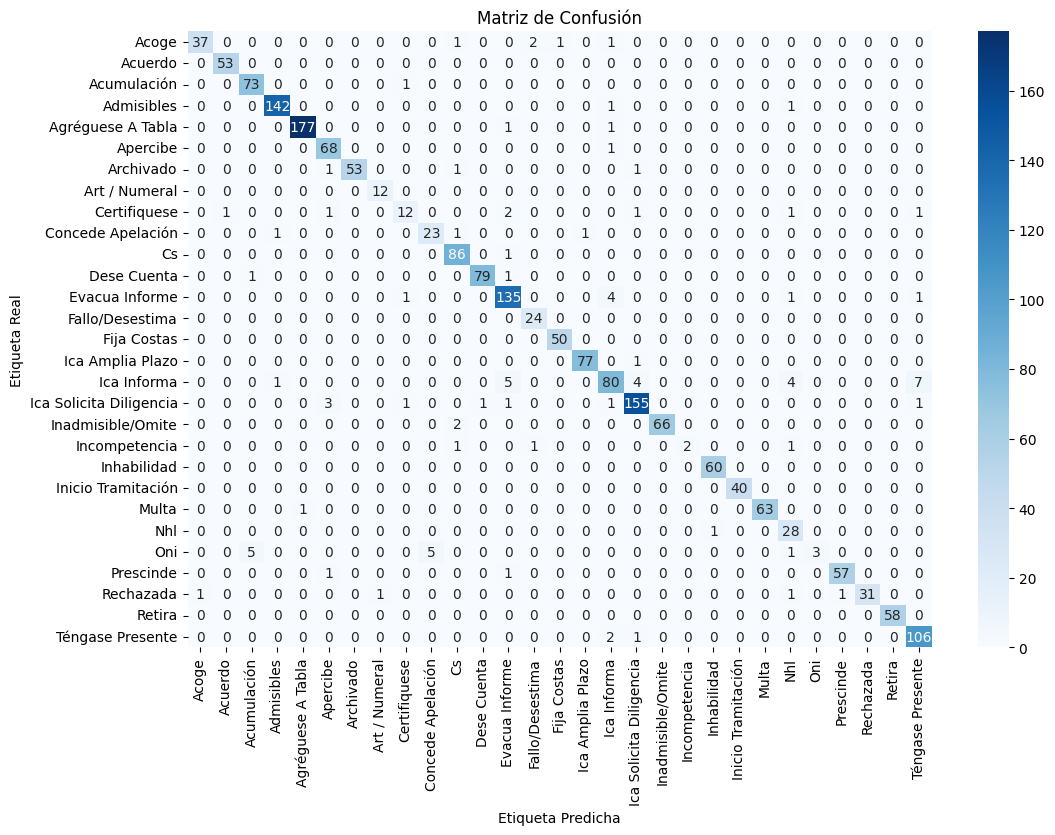

In [228]:
df_smote_3 = metricas_clases(X_test, y_test, model)

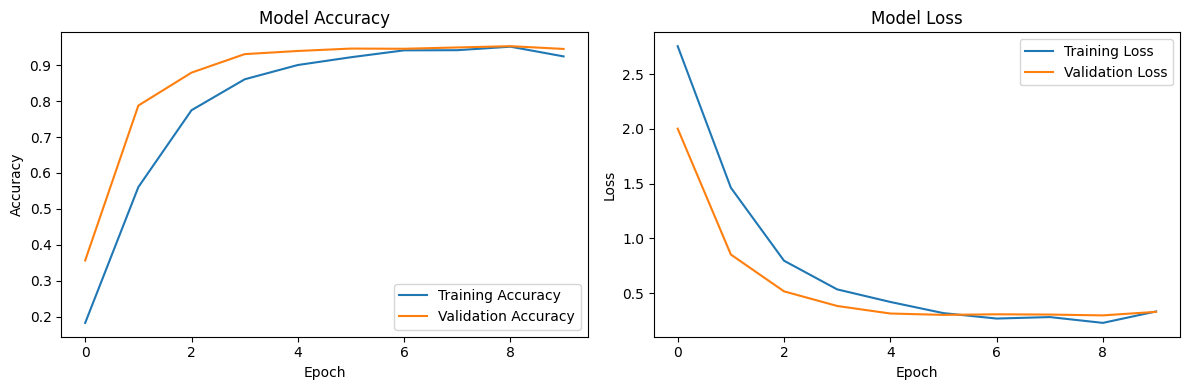

In [229]:
import matplotlib.pyplot as plt

# Graficar la precisión
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Graficar la pérdida
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [218]:
from tensorflow.keras.layers import Bidirectional

# Definición del modelo
model = Sequential()

# Capa de Embedding
model.add(Embedding(input_dim=total_words, output_dim=50, input_length=max_sequence_len))

# Capa LSTM
model.add(Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.0001))))
model.add(Dropout(0.5))

# Capa densa
model.add(Bidirectional(LSTM(64, kernel_regularizer=l2(0.0001))))
model.add(Dropout(0.4))

model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.3))

# Capa de salida
model.add(Dense(y_categorical.shape[1], activation='softmax'))

# Compilación del modelo
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)





c:\DEEP_LEARNING\Project_1\myenv\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [208]:
y_train_int = y_train.argmax(axis=1)  # De one-hot a entero
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_int), y=y_train_int)

class_weights_dict = dict(enumerate(class_weights))

In [209]:

history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=10, batch_size=32, 
                    class_weight=class_weights_dict,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 25s 83ms/step - accuracy: 0.0906 - loss: 3.3240 - val_accuracy: 0.5935 - val_loss: 1.5385 - learning_rate: 0.0010
Epoch 2/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - accuracy: 0.5655 - loss: 1.7453 - val_accuracy: 0.8557 - val_loss: 0.6525 - learning_rate: 0.0010
Epoch 3/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - accuracy: 0.7967 - loss: 0.8683 - val_accuracy: 0.8928 - val_loss: 0.4836 - learning_rate: 0.0010
Epoch 4/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - accuracy: 0.8676 - loss: 0.6140 - val_accuracy: 0.9176 - val_loss: 0.4650 - learning_rate: 0.0010
Epoch 5/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.8700 - loss: 0.5746 - val_accuracy: 0.9330 - val_loss: 0.3782 - learning_rate: 0.0010
Epoch 6/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.9388 - loss: 0.3297 - val_accuracy: 0.9428 - val_loss: 0.3762 - learning_rate: 0.0010
Epoch 7/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - accuracy: 0.9567 - l

61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step
Informe de clasificación:
                         precision    recall  f1-score   support

                  Acoge       0.95      0.88      0.91        42
                Acuerdo       0.96      1.00      0.98        53
            Acumulación       0.96      0.99      0.97        74
             Admisibles       0.98      0.99      0.98       144
      Agréguese A Tabla       1.00      0.97      0.99       179
               Apercibe       0.99      0.99      0.99        69
              Archivado       0.91      0.95      0.93        56
          Art / Numeral       0.71      1.00      0.83        12
           Certifiquese       0.44      0.84      0.58        19
      Concede Apelación       1.00      0.92      0.96        26
                     Cs       0.99      0.97      0.98        87
            Dese Cuenta       0.96      0.96      0.96        81
         Evacua Informe       0.93      0.90      0.92       142
        Fallo/Desestima

c:\DEEP_LEARNING\Project_1\myenv\lib\site-packages\sklearn\metrics\_classification.py:2687: UserWarning: labels size, 28, does not match size of target_names, 29
  warnings.warn(


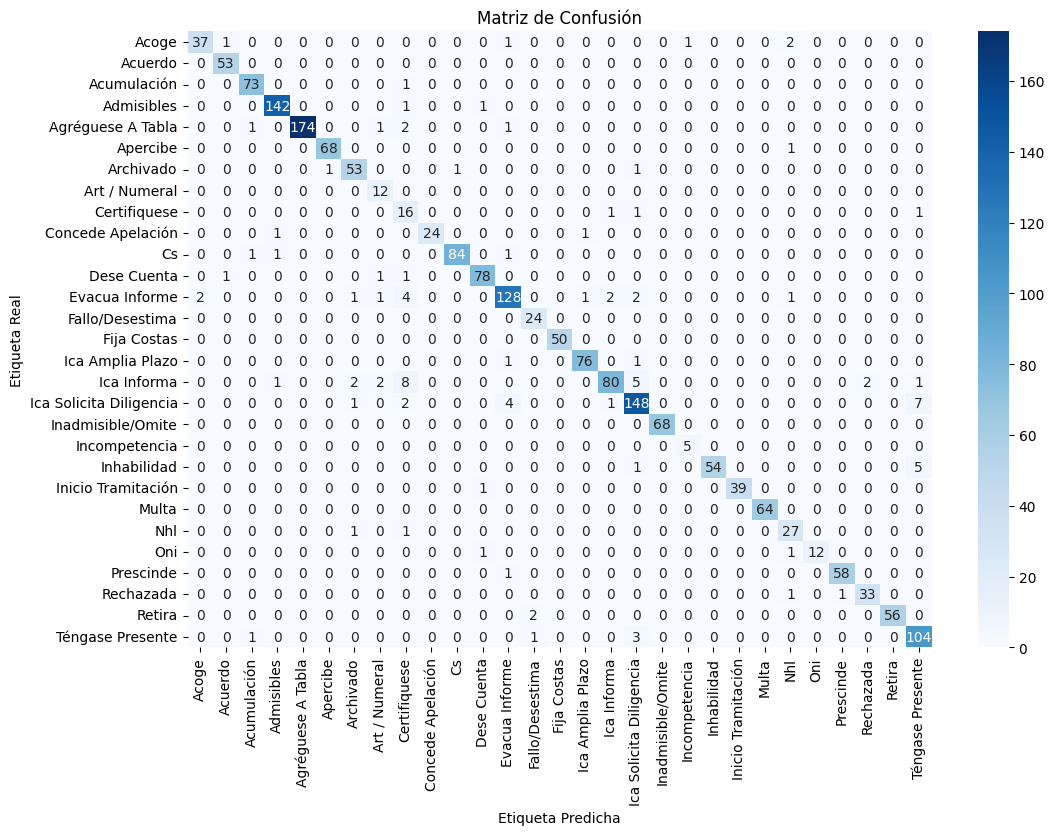

In [210]:
df_balanceweights_3 = metricas_clases(X_test, y_test, model)

In [236]:
# Nuevo texto para probar
new_description = " Agrégue Extra 11-07"

# Limpieza (usa la misma función que creaste anteriormente)
cleaned_description = cleaning_data(new_description)

words = cleaned_description.split()
filtered_words = [word for word in words if word.lower() not in stop_words_es]
cleaned_no_stop = ' '.join(filtered_words)
print(cleaned_no_stop)

# Tokenización del texto
tokenized_description = tokenizer.texts_to_sequences([cleaned_no_stop])

# Padding para que tenga la misma longitud que las secuencias de entrenamiento
padded_description = pad_sequences(tokenized_description, maxlen=max_sequence_len, padding='pre')
# Realizar la predicción
prediction = model.predict(padded_description)

# Ordenar las probabilidades de mayor a menor y obtener los índices de las 3 clases más probables
top_3_indices = prediction[0].argsort()[-3:][::-1]

# Mapear índices a etiquetas originales
top_3_labels = label_encoder.inverse_transform(top_3_indices)

# Obtener las probabilidades correspondientes
top_3_probabilities = prediction[0][top_3_indices]
print("Top 3 predicciones más probables:")
for i in range(3):
    print(f"{i+1}. Clase: {top_3_labels[i]} - Probabilidad: {top_3_probabilities[i]:.2f}")


agregue extra 1107
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Top 3 predicciones más probables:
1. Clase: Ica Amplia Plazo - Probabilidad: 0.93
2. Clase: Agréguese A Tabla - Probabilidad: 0.07
3. Clase: Art / Numeral - Probabilidad: 0.00


In [231]:
# Guardar modelo
model.save('modelo_final.h5')


In [232]:
import pickle

# Guardar el tokenizer
with open('tokenizer_2.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [233]:
with open('label_encoder_2.pickle', 'wb') as handle:
    pickle.dump(label_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
history2 = model.fit(
    X_train, 
    y_train,
    epochs=10, 
    batch_size=32, 
    validation_data = (X_test, y_test),
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - accuracy: 0.1178 - loss: 3.1011 - val_accuracy: 0.3435 - val_loss: 2.0698 - learning_rate: 0.0010
Epoch 2/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 18s 80ms/step - accuracy: 0.3868 - loss: 1.9588 - val_accuracy: 0.6804 - val_loss: 1.1106 - learning_rate: 0.0010
Epoch 3/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 18s 81ms/step - accuracy: 0.6483 - loss: 1.1591 - val_accuracy: 0.8341 - val_loss: 0.6542 - learning_rate: 0.0010
Epoch 4/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - accuracy: 0.7795 - loss: 0.7868 - val_accuracy: 0.9062 - val_loss: 0.4543 - learning_rate: 0.0010
Epoch 5/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step - accuracy: 0.8431 - loss: 0.6211 - val_accuracy: 0.9378 - val_loss: 0.3474 - learning_rate: 0.0010
Epoch 6/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - accuracy: 0.8839 - loss: 0.4485 - val_accuracy: 0.9423 - val_loss: 0.3192 - learning_rate: 0.0010
Epoch 7/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - accuracy: 0.9083 - l

In [96]:
df_csv[['text1', 'text2', 'text3', 'text4', 'text5']] = df_csv['descripcion'].str.split('//', expand=True)

In [97]:
df_filled = df_csv.fillna('')


In [98]:
unique_text1 = set(df_filled['text1'])
unique_text2 = set(df_filled['text2'])
unique_text3 = set(df_filled['text3'])
unique_text4 = set(df_filled['text4'])

In [99]:
all_values = np.concatenate([
    list(unique_text1),
    list(unique_text2),
    list(unique_text3),
    list(unique_text4)
])
all_values = np.array(list(set().union(unique_text1, unique_text2, unique_text3, unique_text4)))

# Obtener valores únicos
unique_values = np.unique(all_values)

print("Valores únicos concatenados:")
print(unique_values)

Valores únicos concatenados:
['' '  Ev. Informe. En relación'
 '  Proveyendo escrito “Ampliación de plazo”: Como se pide, por el tiempo solicitado.'
 ... 'vt3. Cumplimiento con Citación' 'zoom.us/j/92407184252'
 'ऀHabiéndose incurrido en un error involuntario en el nombre de la recurrida de la resolución de fecha cinco de noviembre del año en curso, se rectifica en el sentido que donde dice “Isapre Consalud S.A.” debe decir “Isapre Nueva Mas vida”, manteniéndose inalterada todo lo demás. ऀAtendido lo resuelto precedentemente notifíquese a la Isapre Nueva Mas vida S.A. de acuerdo a lo ordenado en la resolución folio 2, por la vía más rápida debiendo la Sra. Secretaria velar por su oportuno cumplimiento. ऀAl escrito folio 16: Estese al mérito de lo resuelto precedentemente. ऀSuspéndase el decreto de autos en relación.']


In [100]:
len(unique_values)

2774

In [ ]:
for word in unique_values:
    if word.strip() == '':  # Ignorar cadenas vacías
        continue
    
    

    print(cleaned_word)

  Ev. Informe. En relación
  Proveyendo escrito “Ampliación de plazo”: Como se pide, por el tiempo solicitado.
 A Sala Previo Sorteo
 A la presentación de folio 1: Existiendo discordancia entre el nombre de la Isapre contenido en los documentos acompañados y el nombre señalado en el cuerpo del recurso, para resolver, aclárese el nombre de la Isapre contra la cual recurre, dentro de cinco días hábiles, bajo apercibimiento, en caso de incumplimiento, de archivar estos antecedentes.
 A lo principal y al otrosí: No habiéndosele conferido poder a la abogada por la recurrente, no ha lugar por innecesario.
 A lo principal y otro si por acompañado el mandato al tercer otrosi como se pide 
 A lo principal y otrosí: Como se pide a los alegatos. Respecto a la comparecencia remota, atendido el mérito de los antecedentes, constando el domicilio del solicitante, fuera de las ciudades de Antofagasta y Mejillones, y de acuerdo con lo establecido en el Auto Acordado de fecha 7 de octubre del año en cur

In [235]:
import pandas as pd
import numpy as np

# Supongamos que ya tienes estas variables definidas:
# model, tokenizer, label_encoder, unique_values, max_sequence_len

# Crear un DataFrame para almacenar los resultados
results = []

# Clasificar cada palabra única
for word in unique_values:
    if word.strip() == '':  # Ignorar cadenas vacías
        continue
    
    # Limpieza del texto (si es necesario)
    cleaned_description = cleaning_data(word)
    words = cleaned_description.split()
    filtered_words = [word for word in words if word.lower() not in stop_words_es]
    cleaned_no_stop = ' '.join(filtered_words)
    # Tokenización del texto
    tokenized_word = tokenizer.texts_to_sequences([cleaned_no_stop])
    
    # Padding para que tenga la misma longitud que las secuencias de entrenamiento
    padded_word = pad_sequences(tokenized_word, maxlen=max_sequence_len, padding='pre')
    
    # Realizar la predicción
    prediction = model.predict(padded_word)
    
    # Obtener las 3 clases más probables
    top_3_indices = prediction[0].argsort()[-3:][::-1]
    top_3_labels = label_encoder.inverse_transform(top_3_indices)
    top_3_probabilities = prediction[0][top_3_indices]
    
    # Almacenar los resultados
    results.append({
        'Palabra': word,
        'Clase 1': top_3_labels[0],
        'Probabilidad 1': top_3_probabilities[0],
        'Clase 2': top_3_labels[1],
        'Probabilidad 2': top_3_probabilities[1],
        'Clase 3': top_3_labels[2],
        'Probabilidad 3': top_3_probabilities[2]
    })

# Convertir los resultados a un DataFrame
results_df = pd.DataFrame(results)

# Exportar el DataFrame a un archivo Excel
results_df.to_excel('clasificacion_palabras.xlsx', index=False)

print("Clasificación exportada a 'clasificacion_palabras.xlsx'")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━

In [ ]:
label_encoder.classes_

array(['Acoge', 'Acuerdo', 'Acumulación', 'Admisibles',
       'Agréguese A Tabla', 'Apercibe', 'Archivado', 'Art / Numeral',
       'Certifiquese', 'Concede Apelación', 'Cs', 'Dese Cuenta',
       'Evacua Informe', 'Fallo/Desestima', 'Fija Costas',
       'Ica Amplia Plazo', 'Ica Informa', 'Ica Solicita Diligencia',
       'Inadmisible/Omite', 'Incompetencia', 'Inhabilidad',
       'Inicio Tramitación', 'Multa', 'Nhl', 'Oni', 'Prescinde',
       'Rechazada', 'Retira', 'Téngase Presente'], dtype=object)